In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem

import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# R = 0.0083145  # kJ/(mol*K)
R = 0.0019872  # kcal/(mol*K)
T = 298  # K

solvent_dict = {
#     'Acetat': ('CC(=O)[O-]', 'Acetate'),
    'Acetic-acid': ('CC(=O)O', 'Acetic acid', 6.15, 'small acid'),
    'Aceton': ('CC(=O)C', 'Acetone', 20.7, 'polar aprotic'),
    'Acetonitrile': ('CC#N', 'Acetonitrile', 37.5, 'polar aprotic'),
    'Ammonia': ('N', 'Ammonia', 16.61, 'polar aprotic'),
#     'Ammonium': ('[NH4+]', 'Ammonium', 7.1), #ammonium chloride - solid phase. Will adjust with solution conc. 
    'Benzene': ('c1ccccc1', 'Benzene', 2.28, 'nonpolar'),
#     'Benzoat': ('[O-]C(=O)c1ccccc1', 'Benzoate'),
    'Benzylacetat': ('CC(=O)OCc1ccccc1', 'Benzyl acetate', 5.34, 'polar aprotic'),
    'Butanon': ('CCC(=O)C', 'Butanone', 18.85, 'polar aprotic'),
#     'Chloride': ('[Cl-]', 'Chloride', 7.1), #ammonium chloride - solid phase. Will adjust with solution conc.
    'Chloroform': ('C(Cl)(Cl)Cl', 'Chloroform', 4.8, 'nonpolar'),
    'Cyclohexan': ('C1CCCCC1', 'Cyclohexane', 2.02, 'nonpolar'),
    'Di-2-butylamin': ('CC[C@H](C)N[C@H](C)CC', 'Di-2-butylamine', 4.71, 'nonpolar'),
    'Dichlormethan': ('C(Cl)Cl', 'Dichloromethane', 8.93, 'polar aprotic'),
    'Diethanolamin': ('OCCNCCO', 'Diethanolamine', 25.75, 'polar protic'),
#     'Diethanolammonium': ('OCC[NH2+]CCO', 'Diethanolammonium'),
#     'Diethylenamin': ('CCNCC', 'Diethylamine', 3.8, 'nonpolar'), #Average of three sources - 3.6, 3.8, 3.92 all reported.
#     'Diethylenammonium': ('CC[NH2+]CC', 'Diethylenammonium'),
    'Diethylether': ('CCOCC', 'Diethylether',4.33, 'nonpolar'),
    'Dioctylether': ('CCCCCCCCOCCCCCCC', 'Dioctylether', 2, 'nonpolar'), #Estimate
    'DMA': ('CC(=O)N(C)C', 'DMA', 37.8, 'polar aprotic'),
    'DMF': ('CN(C)C=O', 'DMF', 36.7, 'polar aprotic'),
    'DMSO': ('CS(=O)C', 'DMSO', 46.7, 'polar aprotic'),
    'EC': ('C1COC(=O)O1', 'EC', 89.78, 'polar aprotic'),
    'EMC': ('CCOC(=O)OC', 'EMC', 2.99, 'polar aprotic'),
    'Ethanol': ('CCO', 'Ethanol', 24.55, 'polar protic'),
    'Ethylacetat': ('CCOC(=O)C', 'Ethyl acetate', 6.02, 'polar aprotic'),
#     'Ethylenamin': ('C=CN', 'Ethylenamine', 6.94, 'polar protic'),
#     'Ethylenammonium': ('CC[NH3+]', 'Ethylenammonium'),
    'Ethylenglykol': ('OCCO', 'Ethylene glycol', 37.0, 'polar protic'),
#     'Formiat': ('C(=O)[O-]', 'Formate'),
    'Formic-acid': ('O=CO', 'Formic acid', 51.1, 'small acid'),
    'g-Butyrolacton': ('O=C1CCCO1', 'γ-Butyrolactone', 41.68, 'polar aprotic'),
    'Glycerin': ('OCC(O)CO', 'Glycerol', 46.5, 'polar protic'),
    'H2O': ('O', 'Water', 80.1, 'water'),
    'H2SO4': ('O=S(=O)(O)O', 'Sulfuric acid', 100, 'small acid'), #Lots of varying reports 21.9, 100, 84, 80, 106. Chosen 100 for now.
    'Hexafluorbenzol': ('Fc1c(F)c(F)c(F)c(F)c1F', 'Hexafluorobenzene',  2.05, 'nonpolar'),
    'Isooctane': ('CC(C)CC(C)(C)C', 'Isooctane', 1.94, 'nonpolar'),
    'Isopropanol': ('CC(O)C', 'Isopropanol', 17.9, 'polar protic'),
#     'Methanolat': ('C[O-]', 'Methanolate'),
    'n-Hexan': ('CCCCCC', 'n-Hexane', 1.88, 'nonpolar'),
    'Nonandecanol': ('CCCCCCCCCCCCCCCCCCCO', 'Nonandecanol', 3.82, 'fatty alcohol'),
    'Octanol': ('CCCCCCCCO', 'Octanol', 10.3, 'fatty alcohol'),
    'o-Dichlorbenzol': ('Clc1ccccc1Cl', 'o-Dichlorobenzene', 9.93, 'nonpolar'),
#     'Oleic-methyl-ester': ('CCCCCCCCC=CCCCCCCCC(=O)OC', 'Oleic methyl ester', 3.21, 'nonpolar'),
    'Perfluoro-hexan': ('C(C(C(C(F)(F)F)(F)F)(F)F)(C(C(F)(F)F)(F)F)(F)F', 'Perfluorohexane', 1.57, 'nonpolar'),
    'Propylenglykol': ('C[C@@H](O)CO', 'Propylene glycol', 32.0, 'polar protic'),
#     'Tetraethylenammonium': ('CC[N+](CC)(CC)CC', 'Tetraethylenammonium'),
    'THF': ('O1CCCC1', 'THF', 7.58, 'polar aprotic'),
    'Toluol': ('Cc1ccccc1', 'Toluene', 2.38, 'nonpolar'),
    'Tributylphosphat': ('O=P(OCCCC)(OCCCC)OCCCC', 'Tributyl phosphate', 8.29, 'polar aprotic'),
    'Triethanolamin': ('OCCN(CCO)CCO', 'Triethanolamine', 28.11, 'polar protic'),
#     'Triethanolammonium': ('OCC[NH+](CCO)CCO', 'Triethanolammonium'),
#     'Triethylenamin': ('CCN(CC)CC', 'Triethylamine', 2.42, 'nonpolar'),
#     'Triethylenammonium': ('CC[NH+](CC)CC', 'Triethylammonium'),
    'Triglyme': ('COCCOCCOCCOC', 'Triglyme', 7.50, 'polar aprotic'),
    'Urea': ('NC(N)=O', 'Urea', 2.9, 'urea'),
}

# https://www.engineeringtoolbox.com/liquid-dielectric-constants-d_1263.html
# https://people.chem.umass.edu/xray/solvent.html
# https://depts.washington.edu/eooptic/linkfiles/dielectric_chart%5B1%5D.pdf

representative_solvents = ['n-Hexan', 'Benzene', 'Octanol', 'Ethanol', 'H2O']

solvent_keys = list(solvent_dict.keys())
solvent_smiles = list(zip(*solvent_dict.values()))[0]
solvent_names = list(zip(*solvent_dict.values()))[1]
dielctric_constants = list(zip(*solvent_dict.values()))[2]
solvent_classes = list(zip(*solvent_dict.values()))[3]
solvent_class_dict = {s:c for s,c in zip(solvent_keys, solvent_classes)}
solvent_class_name_dict = {s:c for s,c in zip(solvent_names, solvent_classes)}
dielectric_dict = {s:e for s,e in zip(solvent_keys, dielctric_constants)}
dielectric_name_dict = {s:e for s,e in zip(solvent_names, dielctric_constants)}
solvent_key_name_dict = {k:n for k,n in zip(solvent_keys, solvent_names)}
# smiles_to_names_dict = {k:v for k,v in zip(solvents, solvent_names)}
# solvent_class_dict = {v[1]:v[3] for k,v in solvent_dict.items()}
# solvent_class_order = ['nonpolar', 'fatty alcohol', 'polar aprotic', 'polar protic', 'small acid', 'urea', 'water']

In [548]:
mol_df["solvent_class"] = mol_df["solvent"].apply(lambda x: solvent_class_dict[x])

In [435]:
solvent_mols = [Chem.AddHs(Chem.MolFromSmiles(smi)) for smi in solvent_smiles]
solvent_acidity = [AllChem.CalcNumHBD(m) - AllChem.CalcNumHBA(m) for m in solvent_mols]

# for s, a in zip(solvent_names, solvent_acidity):
#     print(s, a)

In [2]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns


def lower_triangular_heatmap(data, col_labels, row_labels, hide_diags=False, annot_fmt=".0f",
                             cbar_title="% Agreement", annot_size=12):
    
    if hide_diags:
        col_labels = col_labels[:-1]
        row_labels = [""] + row_labels[1:]

    mask = np.zeros_like(data, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Want diagonal elements as well
    mask[np.diag_indices_from(mask)] = hide_diags

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(24, 24))

    # Generate a custom diverging colormap
#     cmap = sns.diverging_palette(220, 10, as_cmap=True)
#     cmap = sns.diverging_palette(10, 220, as_cmap=True)
    cmap = sns.diverging_palette(20, 220, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns_plot = sns.heatmap(data, mask=mask, cmap=cmap, annot=True,  fmt=annot_fmt,
                           yticklabels=row_labels, xticklabels=col_labels, annot_kws=dict(size=annot_size),
                           square=True, linewidths=.5, cbar_kws=dict(shrink=.6, pad=-0.1))

    # rotate bottom tick labels
    ax.set_xticklabels(ax.get_xticklabels(),rotation=-40,ha="left",rotation_mode='anchor')
    
    # colorbar font/tick sizes and label
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
    ax.figure.axes[-1].yaxis.label.set_size(12)
    cbar.ax.set_title(cbar_title, fontsize=16, pad=30)
    
    # tick sizes
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12)
    
    
def calculate_logp(mol_id):
    
    mol_df = data_df[data_df["mol_id"]==mol_id]

    water_df = mol_df[mol_df["solvent"]=="H2O"]
    octanol_df = mol_df[mol_df["solvent"]=="Octanol"]

    water_bf = np.exp(-water_df['dG(solution)'] / (R*T)) / np.exp(-water_df['dG(solution)'] / (R*T)).sum()
    octanol_bf = np.exp(-octanol_df['dG(solution)'] / (R*T)) / np.exp(-octanol_df['dG(solution)'] / (R*T)).sum()

    dG_solv_water = (water_df['G(solvation)'] * water_bf).sum()
    dG_solv_octanol = (octanol_df['G(solvation)'] * octanol_bf).sum()

    return (dG_solv_water - dG_solv_octanol) / (R*T*np.log(10)) - 0.8224635

In [3]:
coords_df = pd.read_pickle("../data/debug/dft_coords.pkl.gz")

In [4]:
data_df = pd.read_pickle("../data/debug/free_energy.pkl.gz")
data_df = data_df[data_df['solvent'].isin(solvent_keys)]

# convert everything to kcal/mol
numeric_columns = ['dE(gas)', 'dG(gas)', 'dG(solution)', 'E(gas)',
                   'G(gas)', 'G(solution)', 'G(solvation)', 'G(RRHO)']
data_df[numeric_columns] = data_df[numeric_columns] * 0.239006

# define some additional columns
data_df['G(gas+solvation)'] = data_df['E(gas)'] + data_df['G(solvation)']
data_df['G(gas+RRHO)'] = data_df['E(gas)'] + data_df['G(RRHO)']

pd.set_option('display.max_rows', 20)
data_df

mol_id    conf_id         solvent   dE(gas)   dG(gas)  \
16   epa_DTXCID10593079  conf00013     Acetic-acid  1.621895  1.697899   
17   epa_DTXCID10593079  conf00001     Acetic-acid  1.494744  1.650575   
18   epa_DTXCID10593079  conf00009     Acetic-acid  1.704113  1.605403   
19   epa_DTXCID10593079  conf00002     Acetic-acid  1.811426  1.792306   
20   epa_DTXCID10593079  conf00019     Acetic-acid  0.481836  0.988768   
..                  ...        ...             ...       ...       ...   
97   epa_DTXCID60356272  conf00002  Triethanolamin  3.751438  3.539440   
100  epa_DTXCID60356272  conf00001        Triglyme  0.000000  0.000000   
101  epa_DTXCID60356272  conf00002        Triglyme  3.751438  3.539440   
102  epa_DTXCID60356272  conf00001            Urea  0.000000  0.000000   
103  epa_DTXCID60356272  conf00002            Urea  3.751438  3.539440   

     dG(solution)         E(gas)         G(gas)    G(solution)  G(solvation)  \
16       0.000000 -631023.012375 -630925.302898 -630940.640391    -15.337493   
17       0.077438 -631023.139526 -630925.350222 -630940.562953    -15.212732   
18       0.111855 -631022.930157 -630925.395394 -630940.528537    -15.132904   
19       0.127390 -631022.822843 -630925.208491 -630940.513001    -15.304510   
20       0.208174 -631024.152434 -630926.012029 -630940.432217    -14.420188   
..            ...            ...            ...            ...           ...   
97       1.166110 -389488.130759 -389459.806158 -389469.994745    -10.188587   
100      0.000000 -389491.882197 -389463.345598 -389471.864489     -8.518891   
101      1.193118 -389488.130759 -389459.806158 -389470.671132    -10.864974   
102      0.000000 -389491.882197 -389463.345598 -389469.417545     -6.071947   
103      0.896033 -389488.130759 -389459.806158 -389468.521512     -8.715354   

       G(RRHO)  G(gas+solvation)    G(gas+RRHO)  
16   97.709477    -631038.349868 -630925.302898  
17   97.789066    -631038.352258 -630925.350461  
18   97.534525    -631038.063061 -630925.395633  
19   97.614353    -631038.127354 -630925.208491  
20   98.140405    -631038.572622 -630926.012029  
..         ...               ...            ...  
97   28.324601    -389498.319346 -389459.806158  
100  28.536599    -389500.401088 -389463.345598  
101  28.324601    -389498.995733 -389459.806158  
102  28.536599    -389497.954145 -389463.345598  
103  28.324601    -389496.846113 -389459.806158  

[10126872 rows x 13 columns]

In [5]:
pd.set_option('display.max_rows', 20)
id_to_smi = pd.read_csv("../data/full/id_smiles_all.smi").set_index("ID")
id_to_smi = id_to_smi.groupby(id_to_smi.index).first()
id_to_smi["canon_smi"] = id_to_smi["SMILES"].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
id_to_smi[id_to_smi.index.isin(data_df.mol_id.unique())]

SMILES  \
ID                                                  
ct_AIIV7HW50KNN               CCOC(=O)C(Cl)(Cl)Cl   
ct_AP49BTFIINNN              O=C([O-])c1ccc(I)cc1   
ct_CPKZRRJVN3NS                    CCOP1(=O)CCCO1   
ct_DS1R4YVEKSNN         O=P(Cl)(c1ccccc1)c1ccccc1   
ct_FDD5K5LQMKNN  c1ccc2c3c(cccc13)c1cccc3cccc2c13   
...                                           ...   
pka_extern_2585                    CCCP(=O)(O)CCC   
pka_extern_4534            CCN1CC(O[Si](C)(C)C)C1   
pka_extern_4918  CCOP(=O)([O-])NS(=O)(=O)c1ccccc1   
pka_extern_5150     C[Si](C)(C)OC1CN(Cc2ccccc2)C1   
pka_extern_7054            S=C(Nc1ccccc1)c1ccccc1   

                                          canon_smi  
ID                                                   
ct_AIIV7HW50KNN                 CCOC(=O)C(Cl)(Cl)Cl  
ct_AP49BTFIINNN                O=C([O-])c1ccc(I)cc1  
ct_CPKZRRJVN3NS                      CCOP1(=O)CCCO1  
ct_DS1R4YVEKSNN           O=P(Cl)(c1ccccc1)c1ccccc1  
ct_FDD5K5LQMKNN  c1cc2cccc3c4cccc5cccc(c(c1)c23)c54  
...                                             ...  
pka_extern_2585                      CCCP(=O)(O)CCC  
pka_extern_4534              CCN1CC(O[Si](C)(C)C)C1  
pka_extern_4918    CCOP(=O)([O-])NS(=O)(=O)c1ccccc1  
pka_extern_5150       C[Si](C)(C)OC1CN(Cc2ccccc2)C1  
pka_extern_7054              S=C(Nc1ccccc1)c1ccccc1  

[2203 rows x 2 columns]

## logP validation

In [285]:
logp_df = pd.read_csv("../data/ulrich_logP_pred_soln.csv")
logp_df

mol_id                                             smiles  \
0           molecule_85                                     Brc1ccc(Br)cc1   
1        molecule_31210                                               C#CC   
2         molecule_4246                                        C#CC(C)(C)O   
3    molecule_101616139                                        C#CCCC(C)=O   
4     molecule_65842060  C#CCN1C(=O)COc2cc(F)c(N3C(=O)C4=C(CCCC4)C3=O)cc21   
..                  ...                                                ...   
360     ct_IGBA9LP5NJNN               c1ccc2c(c1)ccc1cc3c(ccc4ccccc43)cc12   
361     ct_CTO8EYMCYHNN                              c1ccc2c(c1)ccc1sccc12   
362       molecule_6361                                     c1cnc2nccnc2c1   
363     pka_extern_1052                            c1cncc([C@@H]2CCCCN2)c1   
364       molecule_4960                                         c1nc[nH]n1   

     n confs  logP (exp)  logP (pred, one conf, gas)  \
0          1        3.79                    3.310284   
1          1        0.94                    1.045318   
2          3        0.28                    1.130329   
3          5        0.58                    0.897557   
4          3        2.55                    3.501865   
..       ...         ...                         ...   
360        1        6.75                    5.491291   
361        1        4.41                    3.709747   
362        1       -0.04                   -0.610024   
363        3        0.97                    2.041083   
364        1       -0.58                   -1.758808   

     logP (pred, one conf, water)  logP (pred, one conf, octanol)  \
0                        3.310284                        3.310284   
1                        1.045318                        1.045318   
2                        1.118410                        1.118410   
3                        0.897557                        0.897557   
4                        3.164977                        3.466634   
..                            ...                             ...   
360                      5.491291                        5.491291   
361                      3.709747                        3.709747   
362                     -0.610024                       -0.610024   
363                      1.396404                        1.396404   
364                     -1.758808                       -1.758808   

     logP (pred, one conf, water/octanol)  logP (pred, boltzmann)  
0                                3.310284                3.310109  
1                                1.045318                1.045318  
2                                1.118410                1.098910  
3                                0.897557                0.775428  
4                                2.916255                3.391106  
..                                    ...                     ...  
360                              5.491291                5.491291  
361                              3.709747                3.709922  
362                             -0.610024               -0.609849  
363                              1.396404                1.554003  
364                             -1.758808               -1.758808  

[365 rows x 9 columns]

In [464]:
# some bulk stats

logp_df["water_error"] = logp_df["logP (pred, one conf, water)"] - logp_df["logP (exp)"]
logp_df["boltz_error"] = logp_df["logP (pred, boltzmann)"] - logp_df["logP (exp)"]

logp_df_many_confs = logp_df[logp_df["n confs"]>50]

# pd.set_option('display.max_rows', 21)

# water_better = logp_df_many_confs[logp_df_many_confs["water_ae"]<logp_df_many_confs["boltz_ae"]]
# print(np.abs(water_better["water_ae"]-water_better["boltz_ae"]).max())
# print(np.mean(np.abs(water_better["water_ae"]-water_better["boltz_ae"])))
# print()
# boltz_better = logp_df_many_confs[logp_df_many_confs["water_ae"]>logp_df_many_confs["boltz_ae"]]
# print(np.abs(boltz_better["water_ae"]-boltz_better["boltz_ae"]).max())
# print(np.mean(np.abs(boltz_better["water_ae"]-boltz_better["boltz_ae"])))

Text(0, 0.5, 'Index')

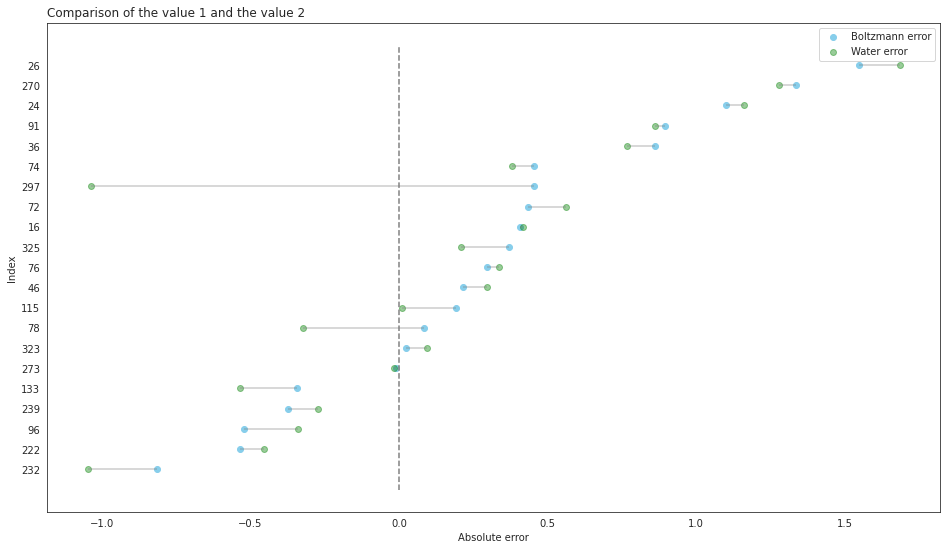

In [465]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

# Reorder it following the values of the first value:
ordered_df = logp_df_many_confs.sort_values(by='boltz_error')
my_range=range(1,len(ordered_df.index)+1)
 
# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=ordered_df['boltz_error'], xmax=ordered_df['water_error'], color='grey', alpha=0.4)
plt.scatter(ordered_df['boltz_error'], my_range, color='skyblue', alpha=1, label='Boltzmann error')
plt.scatter(ordered_df['water_error'], my_range, color='green', alpha=0.4 , label='Water error')
plt.legend()

plt.vlines(x=0, ymin=0, ymax=22, color='grey', linestyle='--')
 
# Add title and axis names
plt.yticks(my_range, ordered_df.index)
plt.title("Comparison of the value 1 and the value 2", loc='left')
plt.xlabel('Absolute error')
plt.ylabel('Index')

In [455]:
my_range

range(1, 22)

In [399]:
sns.pointplot(
    data=logp_df_many_confs,
    
)

0.15670270189654775

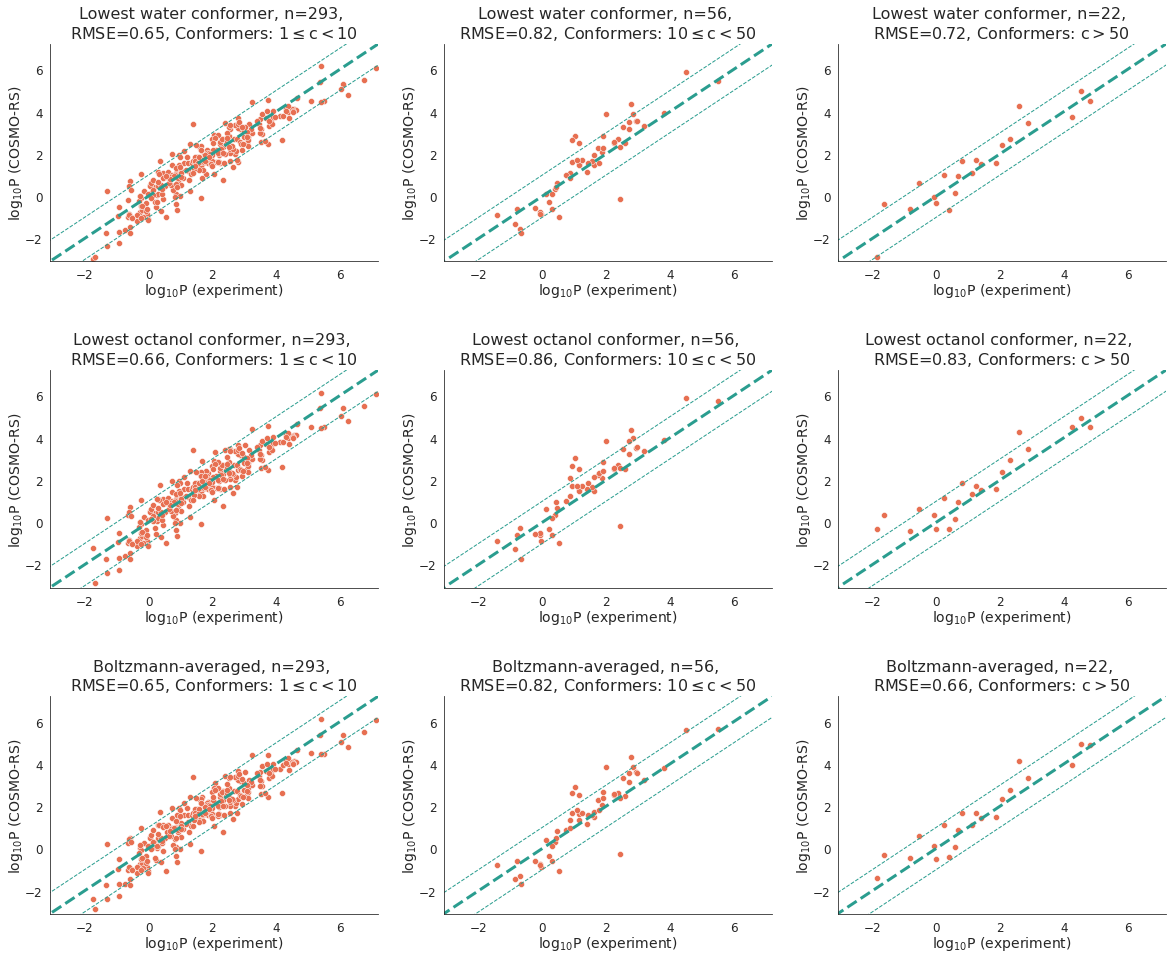

In [308]:
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
sns.set_style("white")

palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]
# ys = ["logP (pred, one conf, water)", "logP (pred, one conf, octanol)", "logP (pred)", "logP (pred, error cancel, both)"]
ys = ["logP (pred, one conf, water)", "logP (pred, one conf, octanol)", "logP (pred, boltzmann)"]
titles = ["Lowest water conformer", "Lowest octanol conformer", "Boltzmann-averaged"] #, "Boltzmann weighted method 2"]
n_confs_cutoff = [1, 10, 50, 9e99]

for i, ax in enumerate(axes.ravel()):
    
    logp_df_n = logp_df[(logp_df["n confs"]>=n_confs_cutoff[(i+3)%3]) & (logp_df["n confs"]<=n_confs_cutoff[(i+3)%3+1])]
    
    sns.scatterplot(
        data=logp_df_n,
        x="logP (exp)",
        y=ys[int(np.floor(i/3))],
        ax=ax,
        color=palette[4]
    )

    sns.lineplot(
        x=np.arange(-10, 9),
        y=np.arange(-10, 9),
        ax=ax,
        linewidth=3,
        linestyle="--",
        color=palette[1]
    )
    
    sns.lineplot(
        x=np.arange(-12, 11),
        y=np.arange(-11, 12),
        ax=ax,
        linewidth=1,
        linestyle="--",
        color=palette[1]
    )
    
    sns.lineplot(
        x=np.arange(-12, 11),
        y=np.arange(-13, 10),
        ax=ax,
        linewidth=1,
        linestyle="--",
        color=palette[1]
    )

    rmse = np.sqrt(np.square(logp_df_n['logP (exp)'] - logp_df_n[ys[int(np.floor(i/3))]]).mean())

    ax.set_ylim(-3.1, 7.2)
    ax.set_xlim(-3.1, 7.2)

    ax.set_xlabel("$\log_{10}$P (experiment)", fontsize=14, labelpad=0)
    ax.set_ylabel("$\log_{10}$P (COSMO-RS)", fontsize=14, labelpad=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    if (i+3)%3!=2:
        ax.set_title(f"{titles[int(np.floor(i/3))]}, n={len(logp_df_n)}, \nRMSE={rmse:.2f}, Conformers: {n_confs_cutoff[(i+3)%3]}$\leq$c$<${n_confs_cutoff[(i+3)%3+1]}", fontsize=16)
    else:
        ax.set_title(f"{titles[int(np.floor(i/3))]}, n={len(logp_df_n)}, \nRMSE={rmse:.2f}, Conformers: c$>${n_confs_cutoff[(i+3)%3]}", fontsize=16)

    
plt.savefig("../exps/plots/logp_validation.pdf", bbox_inches="tight")

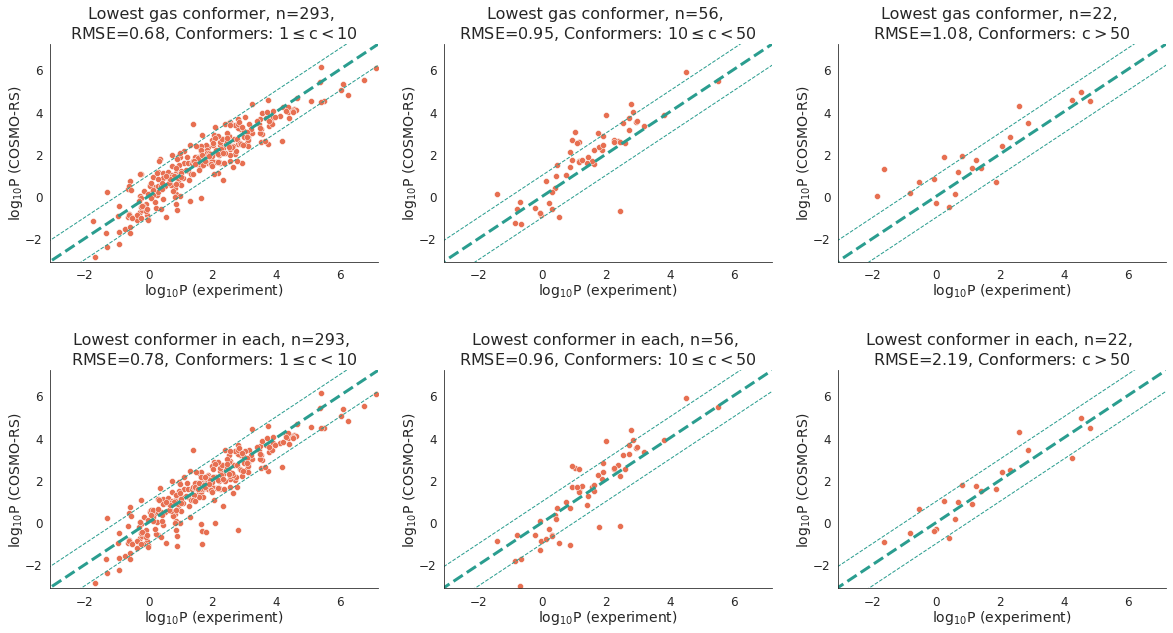

In [410]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
sns.set_style("white")

palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]
ys = ["logP (pred, one conf, gas)", "logP (pred, one conf, water/octanol)"]
titles = ["Lowest gas conformer", "Lowest conformer in each"]
n_confs_cutoff = [1, 10, 50, 9e99]

for i, ax in enumerate(axes.ravel()):
    
    logp_df_n = logp_df[(logp_df["n confs"]>=n_confs_cutoff[(i+3)%3]) & (logp_df["n confs"]<=n_confs_cutoff[(i+3)%3+1])]
    
    sns.scatterplot(
        data=logp_df_n,
        x="logP (exp)",
        y=ys[int(np.floor(i/3))],
        ax=ax,
        color=palette[4]
    )

    sns.lineplot(
        x=np.arange(-10, 9),
        y=np.arange(-10, 9),
        ax=ax,
        linewidth=3,
        linestyle="--",
        color=palette[1]
    )
    
    sns.lineplot(
        x=np.arange(-12, 11),
        y=np.arange(-11, 12),
        ax=ax,
        linewidth=1,
        linestyle="--",
        color=palette[1]
    )
    
    sns.lineplot(
        x=np.arange(-12, 11),
        y=np.arange(-13, 10),
        ax=ax,
        linewidth=1,
        linestyle="--",
        color=palette[1]
    )

    rmse = np.sqrt(np.square(logp_df_n['logP (exp)'] - logp_df_n[ys[int(np.floor(i/3))]]).mean())

    ax.set_ylim(-3.1, 7.2)
    ax.set_xlim(-3.1, 7.2)

    ax.set_xlabel("$\log_{10}$P (experiment)", fontsize=14, labelpad=0)
    ax.set_ylabel("$\log_{10}$P (COSMO-RS)", fontsize=14, labelpad=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    if (i+3)%3!=2:
        ax.set_title(f"{titles[int(np.floor(i/3))]}, n={len(logp_df_n)}, \nRMSE={rmse:.2f}, Conformers: {n_confs_cutoff[(i+3)%3]}$\leq$c$<${n_confs_cutoff[(i+3)%3+1]}", fontsize=16)
    else:
        ax.set_title(f"{titles[int(np.floor(i/3))]}, n={len(logp_df_n)}, \nRMSE={rmse:.2f}, Conformers: c$>${n_confs_cutoff[(i+3)%3]}", fontsize=16)

    
plt.savefig("../exps/plots/logp_validation_worse_cases.pdf", bbox_inches="tight")

## dataset conformer analysis

### run analysis

In [371]:
solvents = data_df.solvent.unique()
n_solvents = len(solvents)
agreement, agreement_counter = np.zeros([len(solvents), len(solvents)]), 0
rrho_agreement, gas_agreement = [], []

dG_solution_dG_solution_pr = np.zeros([len(solvents), len(solvents)])
dE_gas_dG_solution_pr = np.zeros([len(solvents), len(solvents)])
dE_gas_dG_solv_pr = np.zeros([len(solvents), len(solvents)])
dE_gas_dG_rrho_pr = np.zeros([len(solvents), len(solvents)])
spearman_r_counter = 0
threshold = 20

conf_g_correction = []
n_confs_min_for_q = []
n_confs_total = []

partition_factor = 0.95
relative_components_list = []
mol_dfs, conf_dfs = [], []


# build molecule-level and conformer-level dataframes
for mol_id, df in tqdm(data_df.groupby("mol_id")):
    
    # get low energy confs
    # low_energy_confs = df[df['dG(solution)']<threshold].conf_id.unique()
    # df_low_energy_confs = df[df['conf_id'].isin(low_energy_confs)]
    n_confs = len(df.conf_id.unique())
    
    # skip if less than two conformers
    if n_confs > 2:
    
        # lowest energy conformer
        min_conf_soln = df.set_index('conf_id').groupby("solvent")['dG(solution)'].idxmin().sort_index()
        agree = np.array(min_conf_soln.values == min_conf_soln.values[:, None], dtype=int)
        agreement += agree
        agreement_counter += 1

        # does conformer order change after g_solvation and rrho?
        min_conf_gas = df.set_index('conf_id').groupby("solvent")['dE(gas)'].idxmin().sort_index()
        gas_agree = np.array(min_conf_soln.values == min_conf_gas.values, dtype=int)
        gas_agreement.append(gas_agree)       
        
        # partition functions
        q_df = df.sort_values(['solvent', 'dG(solution)'])
        q_df['boltzmann_factor_pre'] = np.exp(-q_df['dG(solution)'] / (R*T))
        q_df['boltzmann_factor'] = q_df.groupby('solvent')['boltzmann_factor_pre'].apply(lambda x: \
                                            x / np.sum(x))
        
        ################################
        ###### CONFORMER ANALYSIS ######
        ################################
        
        # distributions of all intermediate quantities (parent dataframe)
        q_df_solv = q_df.groupby("solvent")
        mol_df = q_df_solv[['E(gas)', 'G(solvation)', 'G(RRHO)', 'G(solution)']]\
                           .apply(lambda x: (x - x.min()).max()).reset_index().sort_values('solvent')

        # how much do conformers influence G(solution)
        # single LEC in solution
        g_soln_lec_soln = q_df.set_index(['solvent', 'conf_id']).loc[zip(min_conf_soln.index, min_conf_soln.values)]\
                                                                .droplevel(level='conf_id').sort_index()['G(solution)']
        
        # ground truth (Boltzmann sum)
        conf_corr_lec_soln = q_df_solv.apply(lambda x: (R*T)*np.log(np.exp(-x["dG(solution)"]/(R*T)).sum()))\
                                      .sort_index()
        g_soln_all_confs = g_soln_lec_soln - conf_corr_lec_soln
        q_df["g_soln_all_confs_diff"] = q_df.apply(lambda x: g_soln_all_confs.loc[x["solvent"]] - x["G(solution)"], axis=1)
        q_df["g_soln_lec_conf_diff"] = q_df.apply(lambda x: g_soln_lec_soln.loc[x["solvent"]] - x["G(solution)"], axis=1)
        g_soln_corr = g_soln_all_confs - g_soln_lec_soln
        
        # single LEC in gas phase
        lec_gas = df.set_index('conf_id').groupby("solvent")['E(gas)'].idxmin().sort_index().values[0]
        g_soln_lec_gas = q_df[q_df["conf_id"]==lec_gas].sort_values('solvent').set_index('solvent')['G(solution)']
        g_soln_corr_lec_gas = g_soln_all_confs - g_soln_lec_gas

        # single LEC in gas phase + solvation
        lec_gas_solv = q_df.set_index('conf_id').groupby("solvent")['G(gas+solvation)'].idxmin().sort_index()
        lec_gas_solv_data = q_df.set_index(['solvent', 'conf_id']).loc[zip(lec_gas_solv.index, lec_gas_solv.values)]\
                                                                  .droplevel(level='conf_id').sort_index()
        g_soln_lec_gas_solv = lec_gas_solv_data['G(solution)']
        g_soln_corr_lec_gas_solv = g_soln_all_confs - g_soln_lec_gas_solv

        # boltzmann average using all confs in gas + solv and RRHO for LEC
        rrho_lec_gas_solv = lec_gas_solv_data['G(RRHO)']
        q_df["g_soln_gas_solv_lec_rrho"] = q_df.apply(lambda x: x["E(gas)"] + \
                                                                x["G(solvation)"] + \
                                                                rrho_lec_gas_solv.loc[x["solvent"]], axis=1)
        conf_corr_lec_gas_solv_lec_rrho = q_df.groupby("solvent")["g_soln_gas_solv_lec_rrho"]\
                                              .apply(lambda x: (R*T)*np.log(np.exp(-(x-x.min())/(R*T)).sum()))\
                                              .sort_index()
        g_soln_boltz_gas_solv_lec_rrho = g_soln_lec_gas_solv - conf_corr_lec_gas_solv_lec_rrho
        g_soln_corr_boltz_gas_solv_lec_rrho = g_soln_all_confs - g_soln_boltz_gas_solv_lec_rrho
        
        # use "relevant" conformers in gas phase
        relevant_gas_df = q_df[np.abs(q_df["dE(gas)"]) < 1].sort_values(['solvent', 'dG(solution)'])\
                                                           .groupby("solvent")
        conf_corr_relevant_gas = relevant_gas_df["G(solution)"].apply(lambda x: (R*T)*np.log(np.exp(-(x - x.min())/(R*T)).sum()))\
                                                               .sort_index()
        g_soln_relevant_gas = g_soln_lec_gas - conf_corr_relevant_gas
        g_soln_corr_relevant_gas = g_soln_all_confs - g_soln_relevant_gas
        
        # update mol_df
        mol_df["mol_id"] = mol_id
        mol_df["g_soln_corr"] = g_soln_corr.values
        mol_df["g_soln_corr_lec_gas"] = g_soln_corr_lec_gas.values
        mol_df["g_soln_corr_lec_gas_solv"] = g_soln_corr_lec_gas_solv.values
        mol_df["g_soln_corr_boltz_gas_solv_lec_rrho"] = g_soln_corr_boltz_gas_solv_lec_rrho.values
        mol_df["g_soln_corr_relevant_gas"] = g_soln_corr_relevant_gas.values
        
        mol_df["g_soln_corr_abs"] = np.abs(g_soln_corr.values)
        mol_df["g_soln_corr_lec_gas_abs"] = np.abs(g_soln_corr_lec_gas.values)
        mol_df["g_soln_corr_lec_gas_solv_abs"] = np.abs(g_soln_corr_lec_gas_solv.values)
        mol_df["g_soln_corr_boltz_gas_solv_lec_rrho_abs"] = np.abs(g_soln_corr_boltz_gas_solv_lec_rrho.values)
        mol_df["g_soln_corr_relevant_gas_abs"] = np.abs(g_soln_corr_relevant_gas.values)
        
        mol_df["min_conf_gas"] = min_conf_gas.values
        mol_df["min_conf_solv"] = lec_gas_solv.values
        mol_df["min_conf_soln"] = min_conf_soln.values
        
        # how many conformers needed to get within x kcal/mol of true value
        q_df["g_soln_all_confs_cum_diff"] = q_df_solv.apply(lambda x: g_soln_all_confs.loc[x['solvent'].values[0]] - 
                                                                      (g_soln_lec_soln.loc[x['solvent'].values[0]] - \
                                                                      (R*T)*np.log(np.exp(-x["dG(solution)"]/(R*T)).cumsum()))).sort_index().values
        
        # now do this in reverse order (assume lowest energy conformer is added last)
        q_df_solv_flipped = q_df.sort_values(["solvent", "dG(solution)"], ascending=[True, False]).groupby("solvent")
        q_df["g_soln_all_confs_cum_diff_rev"] = q_df_solv_flipped\
                .apply(lambda x: g_soln_all_confs.loc[x['solvent'].values[0]] - 
                                 (x['G(solution)'] - \
                                 (R*T)*np.log(np.exp(-x["dG(solution)"]/(R*T)).cumsum()))).sort_index().values

        
        # relative components of all important quantities (slow)
#         lec_soln_components = q_df.set_index(['solvent', 'conf_id']).loc[zip(min_conf_soln.index, min_conf_soln.values)]\
#                           .droplevel(level='conf_id').sort_index()[["E(gas)", "G(solvation)", "G(RRHO)", "G(solution)"]]
#         relative_components = q_df.apply(lambda x: x[["E(gas)", "G(solvation)", "G(RRHO)", "G(solution)"]] - \
#                            lec_soln_components.loc[x["solvent"]], axis=1)
#         relative_components["solvent"] = q_df["solvent"]
#         relative_components["conf_id"] = q_df["conf_id"]
#         relative_components["mol_id"] = mol_id
#         relative_components_list.append(relative_components)
        
        # update dfs
        mol_df["n_confs"] = n_confs
        mol_dfs.append(mol_df)
        conf_dfs.append(q_df)
    
    
# agreement = agreement/agreement_counter * 100
# gas_agreement = gas_agreement/agreement_counter * 100

# dG_solution_dG_solution_pr = dG_solution_dG_solution_pr/spearman_r_counter
# dE_gas_dG_solution_pr = dE_gas_dG_solution_pr/spearman_r_counter
# dE_gas_dG_solv_pr = dE_gas_dG_solv_pr/spearman_r_counter
# dE_gas_dG_rrho_pr = dE_gas_dG_rrho_pr/spearman_r_counter

mol_df = pd.concat(mol_dfs).reset_index()
conf_df = pd.concat(conf_dfs).reset_index()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2203/2203 [14:11<00:00,  2.59it/s]


In [439]:
def add_mol_properties(test_mol_df):
    
    present_mol_ids = test_mol_df.mol_id.unique()
    mol_id_to_smi_dict = {m_id: id_to_smi.loc[m_id]["canon_smi"] for m_id in present_mol_ids}
    # mol_id_to_mol_dict = {m_id: Chem.AddHs(Chem.MolFromSmiles(mol_id_to_smi_dict[m_id])) \
    #                       for m_id in present_mol_ids}
    mol_id_to_mol_dict = {m_id: Chem.MolFromSmiles(mol_id_to_smi_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_n_rotatable_bonds = {m_id: AllChem.CalcNumRotatableBonds(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_num_rings = {m_id: AllChem.CalcNumRings(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_n_hbd = {m_id: AllChem.CalcNumHBD(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_n_hba = {m_id: AllChem.CalcNumHBA(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_mol_weight = {m_id: AllChem.CalcExactMolWt(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    mol_id_to_atoms = {m_id: [a.GetSymbol() for a in mol_id_to_mol_dict[m_id].GetAtoms()] for m_id in present_mol_ids}
    mol_id_to_max_fc = {m_id: np.max([a.GetFormalCharge() for a in mol_id_to_mol_dict[m_id].GetAtoms()]) for m_id in present_mol_ids}
    mol_id_to_min_fc = {m_id: np.min([a.GetFormalCharge() for a in mol_id_to_mol_dict[m_id].GetAtoms()]) for m_id in present_mol_ids}
    mol_id_to_fc = {m_id: Chem.GetFormalCharge(mol_id_to_mol_dict[m_id]) for m_id in present_mol_ids}
    
    test_mol_df["solvent_class"] = test_mol_df["solvent"].apply(lambda x: solvent_class_dict[x])
    test_mol_df["solute_smi"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_smi_dict[x])
    test_mol_df["mol"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_mol_dict[x])
    test_mol_df["n_rotatable_bonds"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_n_rotatable_bonds[x])
    test_mol_df["num_rings"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_num_rings[x])
    test_mol_df["n_hbd"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_n_hbd[x])
    test_mol_df["n_hba"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_n_hba[x])
    test_mol_df["mol_weight"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_mol_weight[x])
    test_mol_df["atoms"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_atoms[x])
    test_mol_df["max_fc"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_max_fc[x])
    test_mol_df["min_fc"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_min_fc[x])
    test_mol_df["fc"] = test_mol_df["mol_id"].apply(lambda x: mol_id_to_fc[x])
    
    test_mol_df["ion"] = "none"
    test_mol_df.loc[test_mol_df["fc"]>0, "ion"] = "cation"
    test_mol_df.loc[test_mol_df["fc"]<0, "ion"] = "anion"
    test_mol_df.loc[(test_mol_df["fc"]==0) & ((test_mol_df["max_fc"]!=0) | (test_mol_df["min_fc"]!=0)), "ion"] = "zwitterion"

    bins = [0, 100, 200, 300, 400, 500 ,600]
    test_mol_df["mol_weight_binned"] = pd.cut(test_mol_df["mol_weight"], bins)
    
    rotatable_bond_bins = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 12]
    test_mol_df["n_rotatable_bonds_binned"] = pd.cut(test_mol_df["n_rotatable_bonds"], rotatable_bond_bins)
    
    # can only run this line once
    unique_atoms = set().union(*test_mol_df.atoms.values.tolist())
    atoms_df = pd.DataFrame(list(test_mol_df.apply(lambda row: {a:row["atoms"].count(a) for a in unique_atoms}, axis=1)))
    test_mol_df = pd.concat([test_mol_df, atoms_df], axis=1)
    
    test_mol_df["n_hetero_atoms"] = test_mol_df[unique_atoms].sum(axis=1) - test_mol_df[["C"]].sum(axis=1)
    test_mol_df["percent_hetero_atoms"] = test_mol_df["n_hetero_atoms"] / test_mol_df[unique_atoms].sum(axis=1)
    
    return test_mol_df


mol_df = pd.concat(mol_dfs).reset_index()
mol_df = add_mol_properties(mol_df)

### what is the effect of conformers when compared to lowest energy conformer in solution
dG(soln)_0 will be strictly smaller than the boltzmann-averaged dG(soln)

should check this among many solute/solvent splits

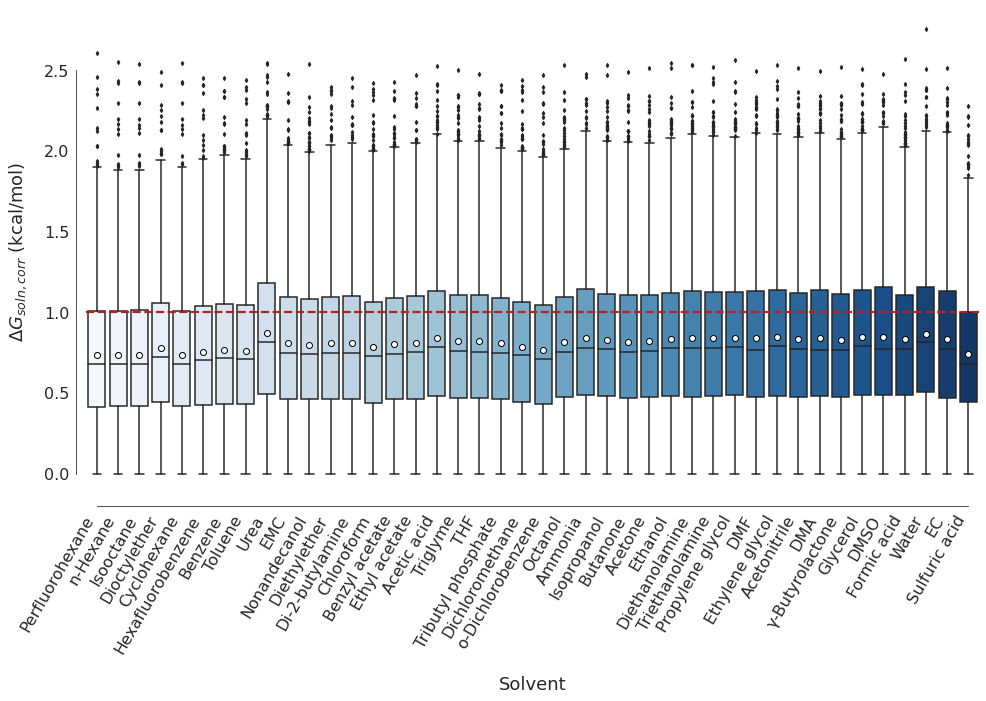

In [481]:
# first, across all solvents indiscriminate of solutes

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

ax1.hlines(1, -0.5, 41.5, linewidth=2.2, linestyle="--", color='firebrick')

sns.boxplot(
    data=mol_df,
    x='solvent',
    y='g_soln_corr_abs',
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=True,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"},
    flierprops={"marker":'d', "markersize":3},
)


sns.despine(offset=10, trim=True)
ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

plt.savefig("../exps/plots/g_corr_per_solvent.pdf", bbox_inches="tight")

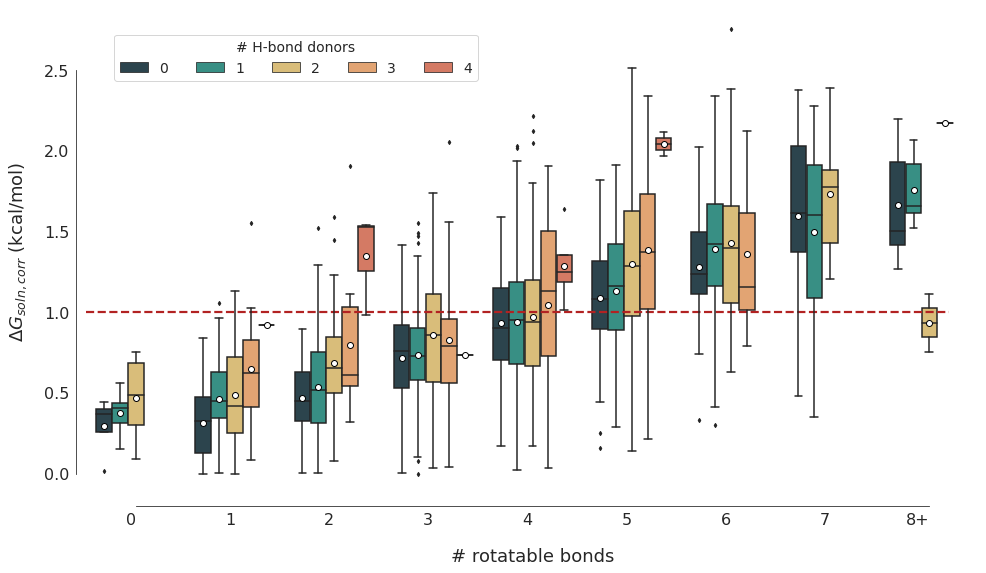

In [479]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

ax1.hlines(1, -0.5, 8.2, linewidth=2.2, linestyle="--", color='firebrick')

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="H2O") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds_binned',
    y='g_soln_corr_abs',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"},
    flierprops={"marker":'d', "markersize":3},
#     cut=0,
)

sns.despine(offset=10, trim=True)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
x_labels = [str(i) for i in range(8)] + ["8+"]
ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

# ax1.set_title("Effect of conformers on $\Delta G_{soln}$ in water", fontsize=22, pad=10)

plt.savefig("../exps/plots/g_soln_corr_water.pdf", bbox_inches="tight")

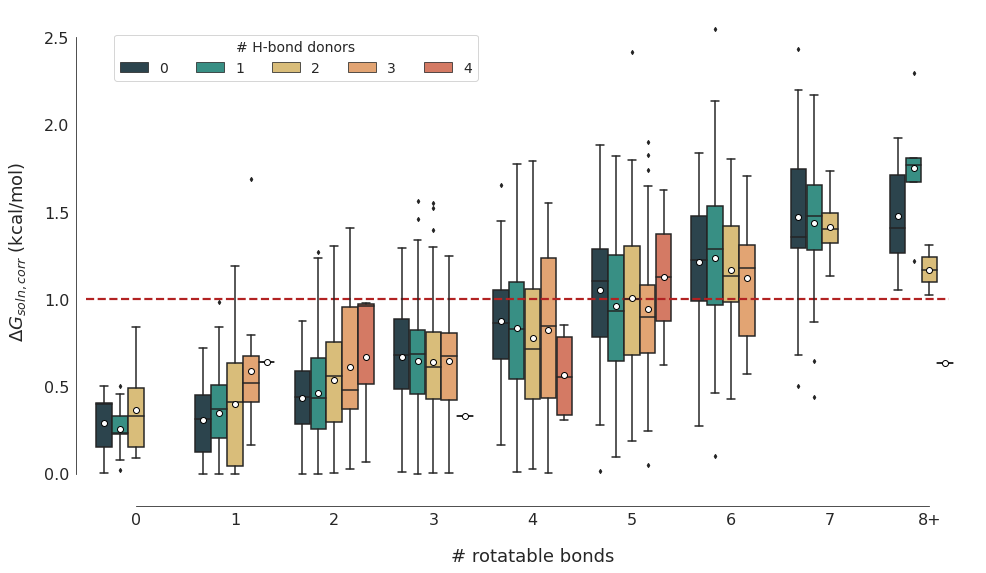

In [480]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

ax1.hlines(1, -0.5, 8.2, linewidth=2.2, linestyle="--", color='firebrick')

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="n-Hexan") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds_binned',
    y='g_soln_corr_abs',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"},
    flierprops={"marker":'d', "markersize":3},
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
x_labels = [str(i) for i in range(8)] + ["8+"]
ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

sns.despine(offset=10, trim=True)
# ax1.set_title("Effect of conformers on $\Delta G_{soln}$ in n-hexanes", fontsize=22, pad=10)

plt.savefig("../exps/plots/g_soln_corr_hexanes.pdf", bbox_inches="tight")

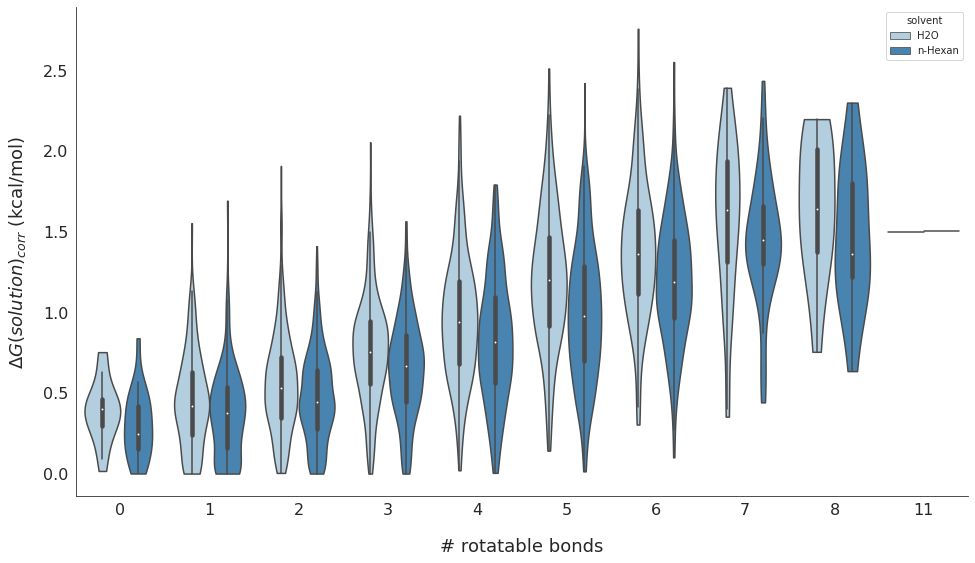

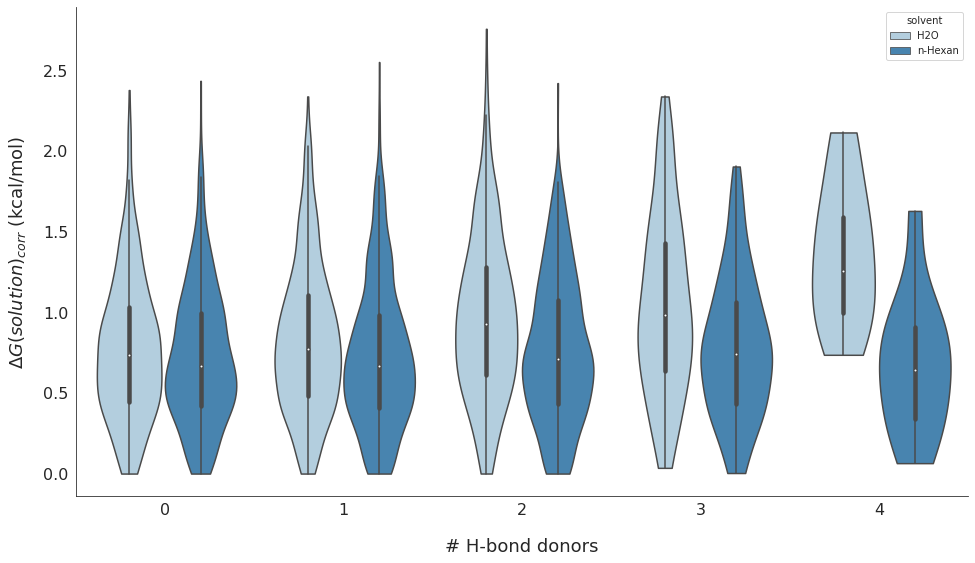

In [51]:
# test solute-level features with water and n-hexanes

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.violinplot(
    data=mol_df[(mol_df["solvent"]=="H2O") | (mol_df["solvent"]=="n-Hexan")],
    x='n_rotatable_bonds',
    y='g_soln_corr_abs',
    ax=ax1,
    palette="Blues",
    hue="solvent",
    showfliers=True,
    cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G(solution)_{corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)




fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.violinplot(
    data=mol_df[(mol_df["solvent"]=="H2O") | (mol_df["solvent"]=="n-Hexan")],
    x='n_hbd',
    y='g_soln_corr_abs',
    ax=ax1,
    palette="Blues",
    hue="solvent",
    showfliers=True,
    cut=0,
)

ax1.set_xlabel("# H-bond donors", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G(solution)_{corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

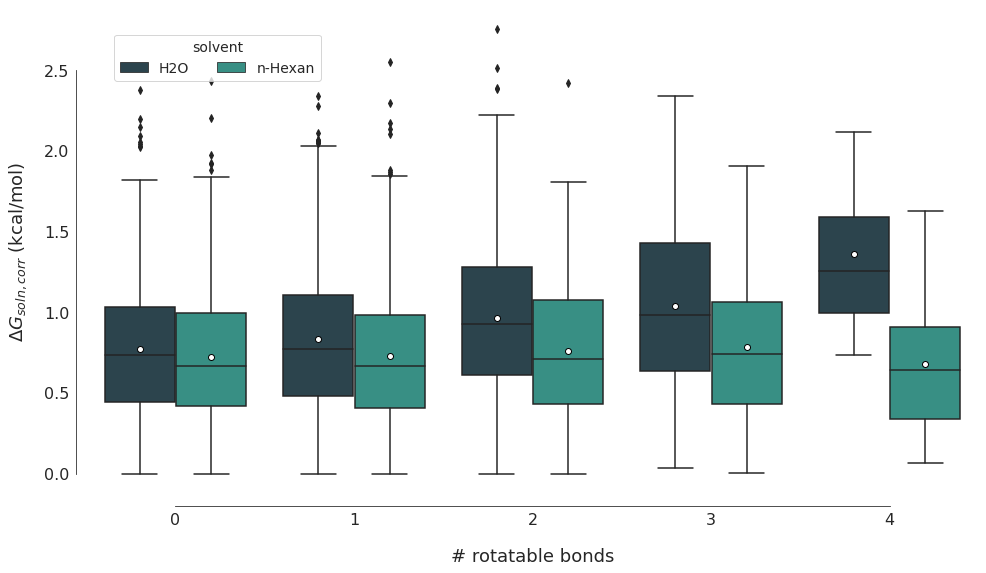

In [131]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"].isin(["n-Hexan", "H2O"])) & ((mol_df["n_hbd"]<5))],
    x='n_hbd',
    y='g_soln_corr_abs',
    ax=ax1,
    palette=palette,
    hue="solvent",
    showfliers=True,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"}
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
x_labels = [str(i) for i in range(8)] + ["8+"]
# ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.legend(ncol=5, fontsize=14, title="solvent", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

sns.despine(offset=10, trim=True)
# ax1.set_title("Effect of conformers on $\Delta G_{soln}$ in n-hexanes", fontsize=22, pad=10)

# plt.savefig("../exps/plots/g_soln_corr_hexanes.pdf", bbox_inches="tight")

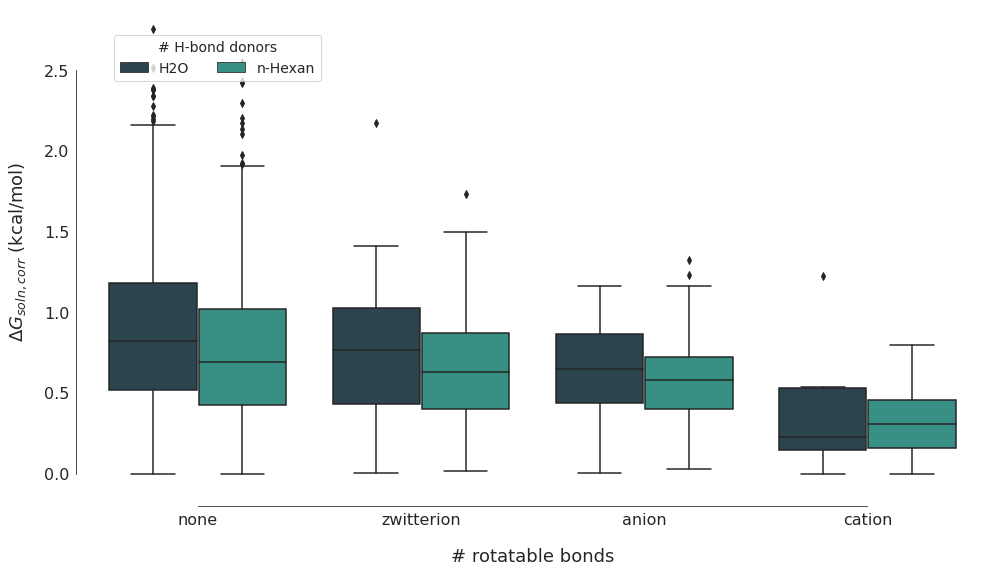

In [133]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"].isin(["H2O", "n-Hexan"])) & ((mol_df["n_hbd"]<5))],
    x='ion',
    y='g_soln_corr_abs',
    ax=ax1,
    palette=palette,
    hue="solvent",
    showfliers=True,
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

sns.despine(offset=10, trim=True)
# ax1.set_title("Effect of conformers on $\Delta G_{soln}$ in water", fontsize=22, pad=10)

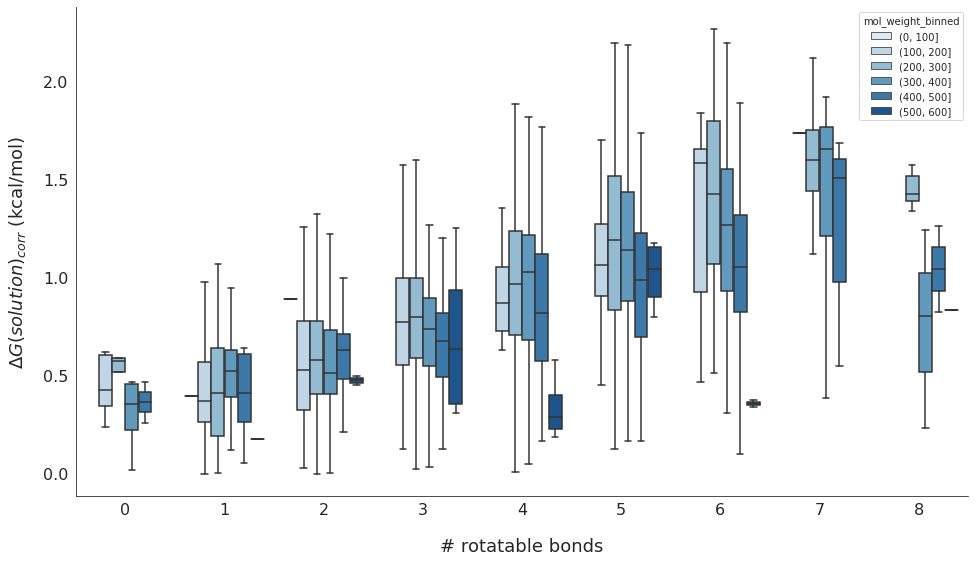

In [632]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="H2O") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds',
    y='corr_lec_soln_abs',
    ax=ax1,
    palette="Blues",
    hue="mol_weight_binned",
    showfliers=False,
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G(solution)_{corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

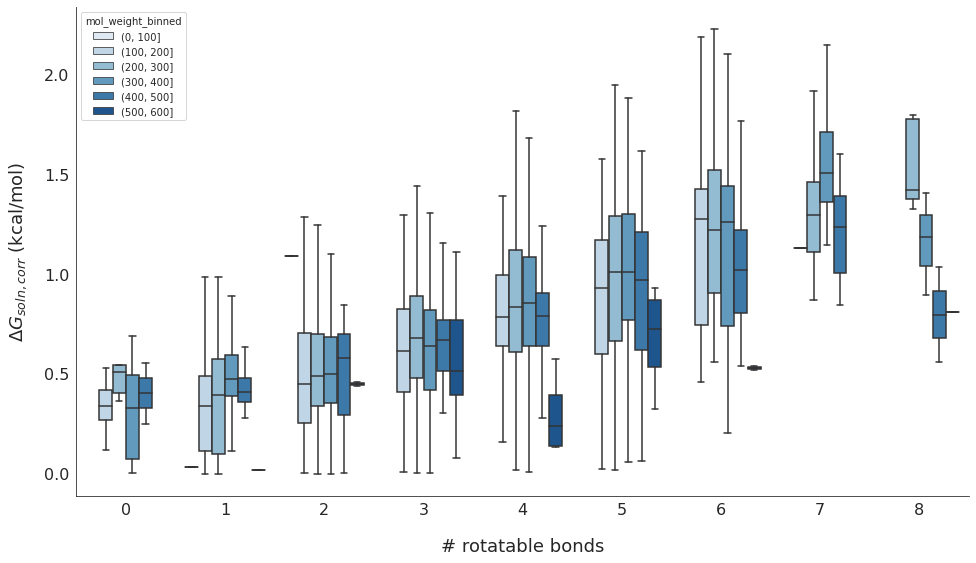

In [634]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="n-Hexan") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds',
    y='corr_lec_soln_abs',
    ax=ax1,
    palette="Blues",
    hue="mol_weight_binned",
    showfliers=False,
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

conf_df_long = conf_df.melt(id_vars=['solvent', 'num_rings', 'n_hbd', 'n_hba', 'n_rotatable_bonds'],
                            value_vars=["corr_lec_gas", "corr_lec_gas_solv", "corr_boltz_gas_solv"],
                            var_name='stat', value_name='val')

sns.boxplot(
    data=conf_df_long[(conf_df_long["solvent"]=="H2O")],
    x='stat',
    y='val',
    hue='n_rotatable_bonds',
    ax=ax1,
    palette="Blues",
    showfliers=False,
)

ax1.set_xlim(-0.5, 2.5)
plt.hlines(0, xmin=-0.5, xmax=2.5)

ax1.get_legend().remove()

### error using lowest energy conformer in gas phase

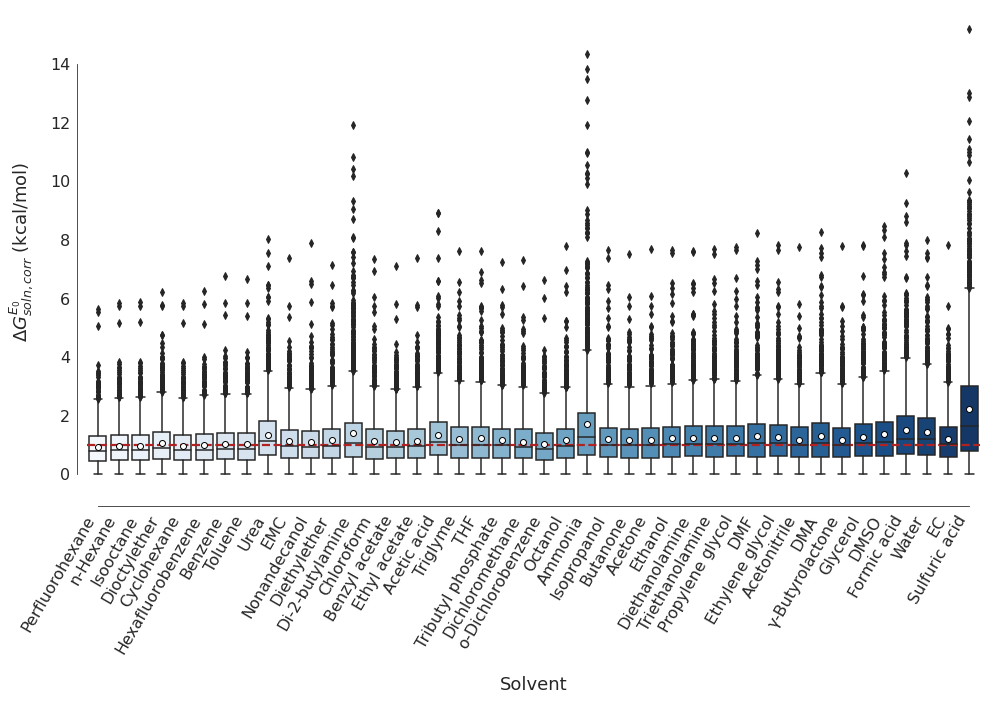

In [415]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

ax1.hlines(1, -0.5, 41.5, linewidth=2.2, linestyle="--", color='firebrick')

sns.boxplot(
    data=mol_df,
    x='solvent',
    y='g_soln_corr_lec_gas_abs',
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=True,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"}
)

sns.despine(offset=10, trim=True)
ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}^{E_0}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

plt.savefig("../exps/plots/g_corr_lec_gas_per_solvent.pdf", bbox_inches="tight")

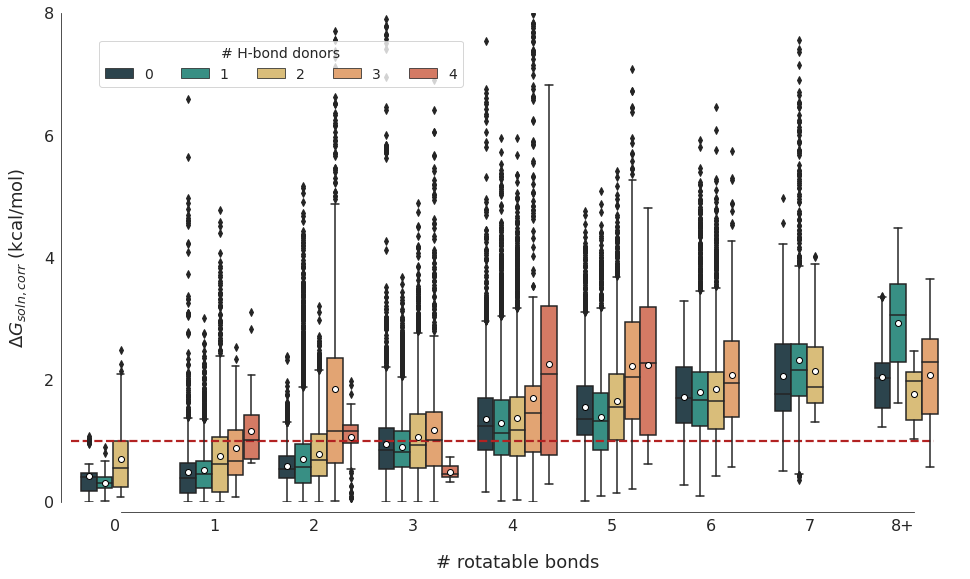

In [411]:
problem_solvents = ['Ammonia', 'Di-2-butylamin', 'Formic-acid', 'H2SO4']

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

ax1.hlines(1, -0.5, 8.2, linewidth=2.2, linestyle="--", color='firebrick')

sns.boxplot(
    data=mol_df[((mol_df["n_hbd"]<5)) & (~mol_df["solvent"].isin(problem_solvents))],
    x='n_rotatable_bonds_binned',
    y='g_soln_corr_lec_gas_abs',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"}
)

sns.despine(offset=10, trim=True)
ax1.set_ylim(0, 8)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
x_labels = [str(i) for i in range(8)] + ["8+"]
ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

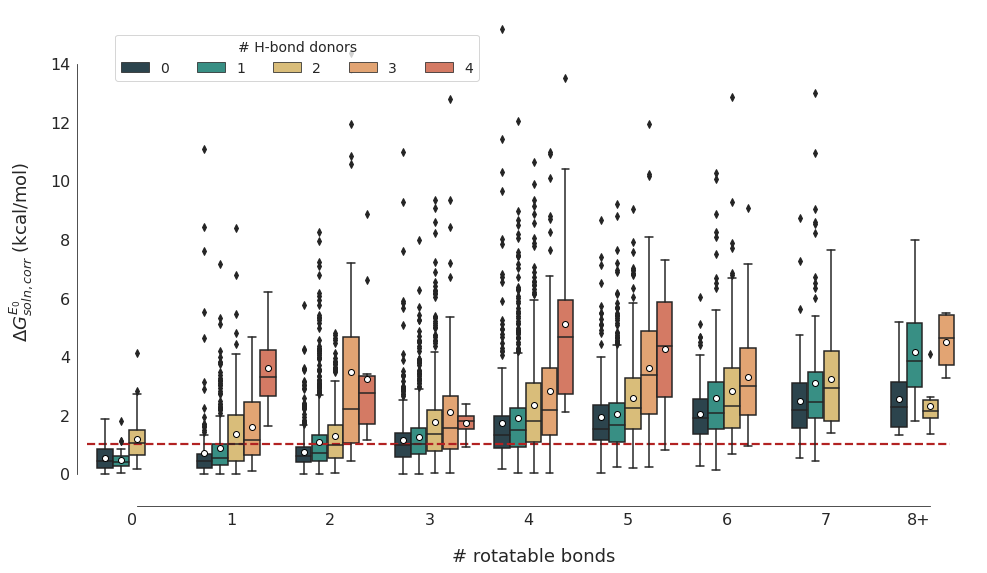

In [413]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

ax1.hlines(1, -0.5, 8.2, linewidth=2.2, linestyle="--", color='firebrick')

sns.boxplot(
    data=mol_df[((mol_df["n_hbd"]<5)) & (mol_df["solvent"].isin(problem_solvents))],
    x='n_rotatable_bonds_binned',
    y='g_soln_corr_lec_gas_abs',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"}
)

sns.despine(offset=10, trim=True)
# ax1.set_ylim(0, 14)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}^{E_0}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
x_labels = [str(i) for i in range(8)] + ["8+"]
ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

plt.savefig("../exps/plots/g_corr_lec_gas_problem_solvents.pdf", bbox_inches="tight")

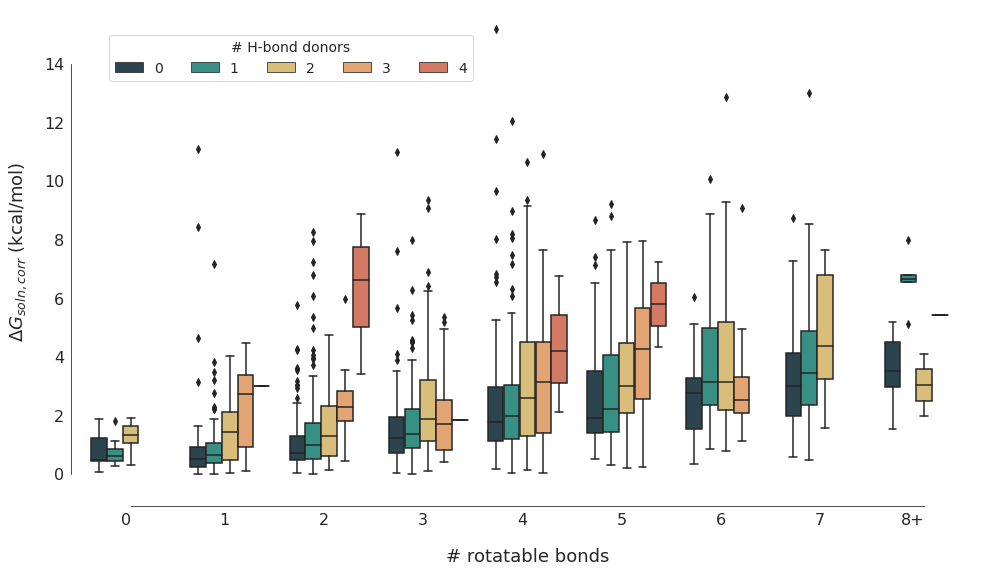

In [175]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[((mol_df["n_hbd"]<5)) & (mol_df["solvent"]=="H2SO4")],
    x='n_rotatable_bonds_binned',
    y='g_soln_corr_lec_gas_abs',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

sns.despine(offset=10, trim=True)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
x_labels = [str(i) for i in range(8)] + ["8+"]
ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

In [162]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[((mol_df["n_hbd"]<5)) & (mol_df["g_soln_corr_lec_gas_abs"]>1)],
    x='n_rotatable_bonds_binned',
    y='g_soln_corr_lec_gas_abs',
    ax=ax1,
    palette=palette,
    hue="problem_solvents",
    showfliers=True,
#     cut=0,
)

sns.despine(offset=10, trim=True)
ax1.set_ylim(0, 12)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


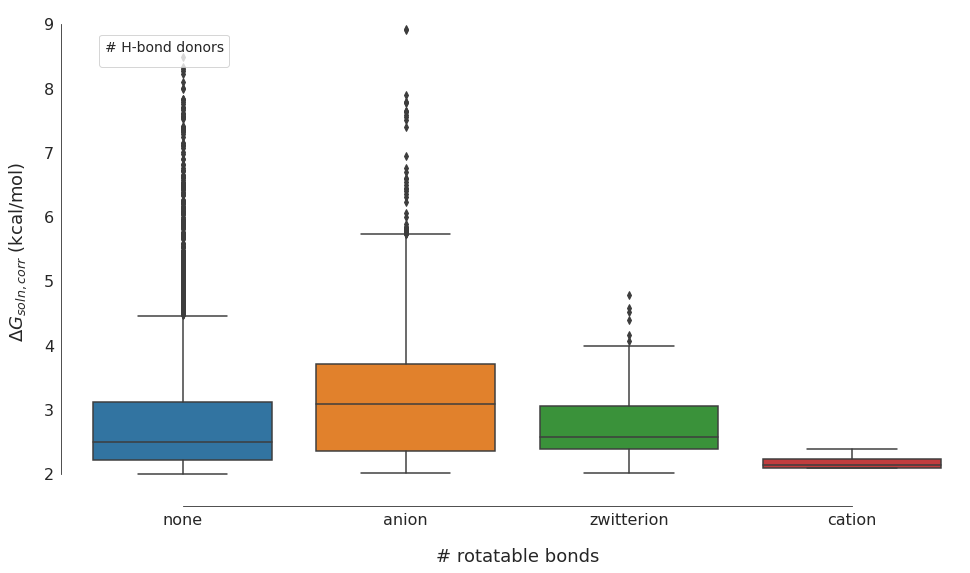

In [169]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["g_soln_corr_lec_gas_abs"]>2) & (~mol_df["solvent"].isin(problem_solvents))],
    x='ion',
#     hue='n_hbd',
    y='g_soln_corr_lec_gas_abs',
    ax=ax1,
#     palette=palette,
    showfliers=True,
#     cut=0,
)

sns.despine(offset=10, trim=True)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

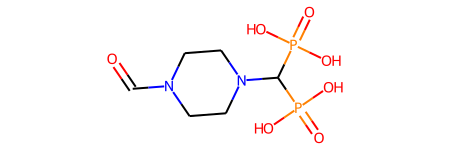

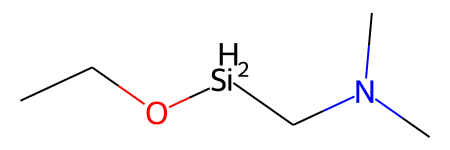

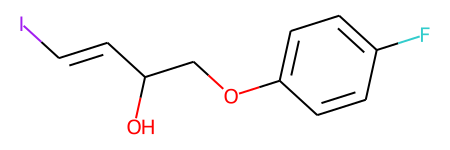

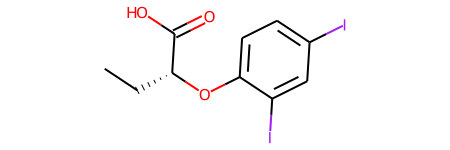

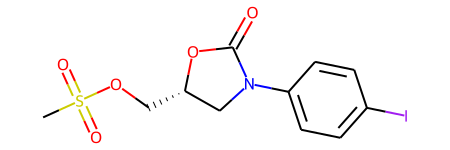

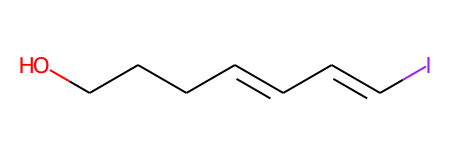

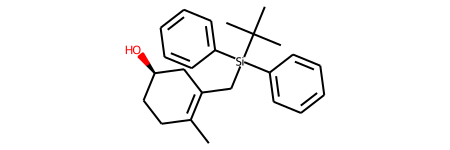

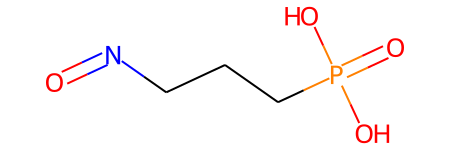

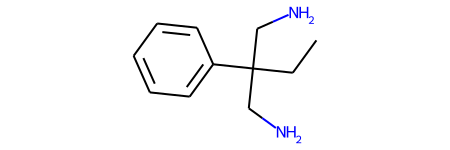

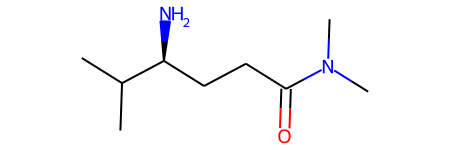

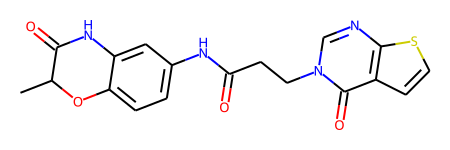

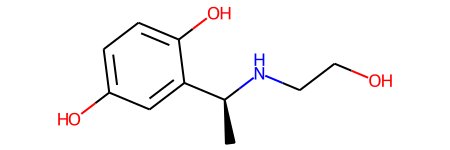

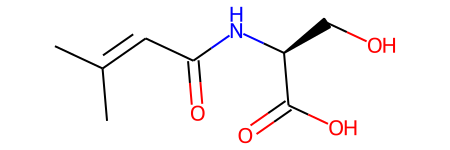

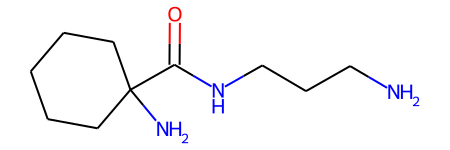

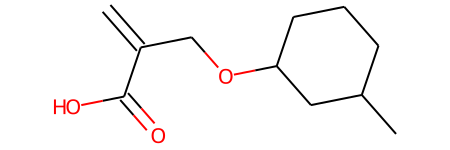

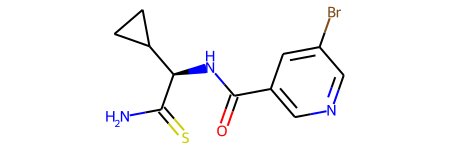

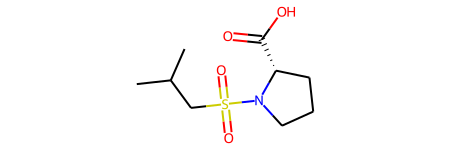

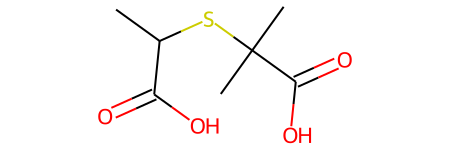

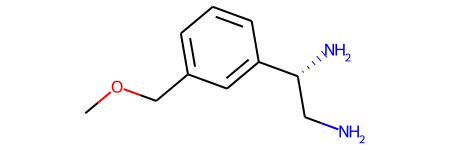

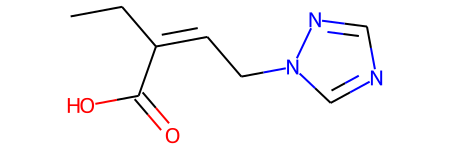

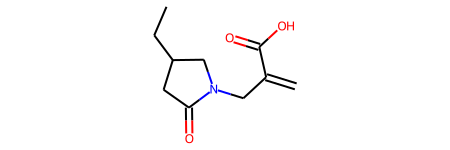

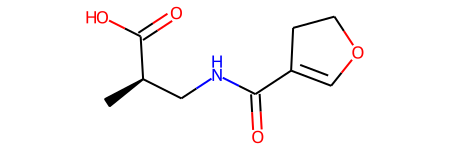

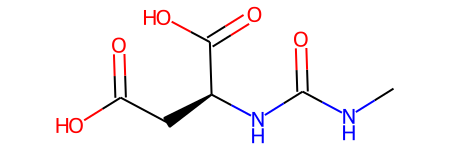

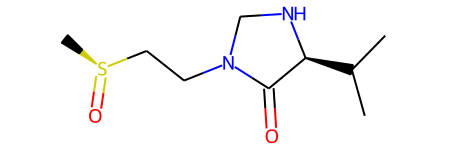

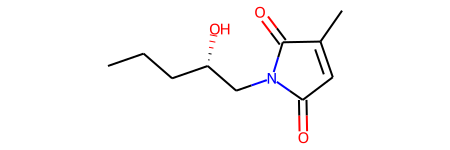

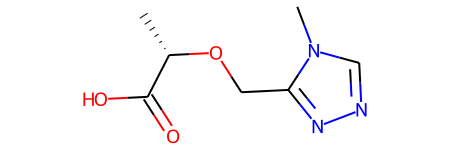

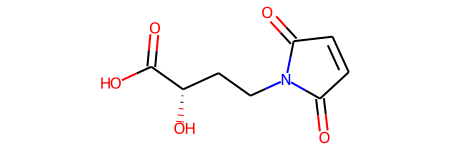

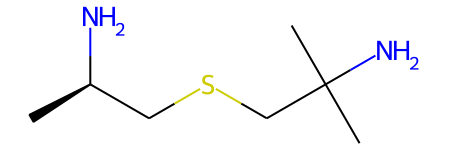

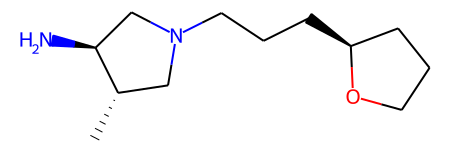

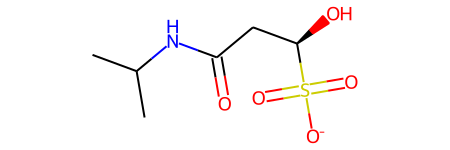

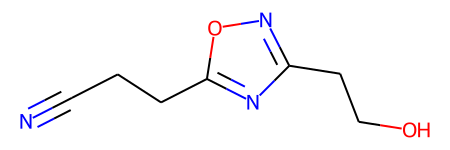

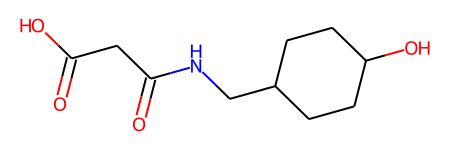

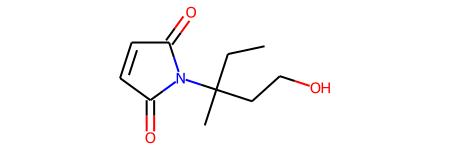

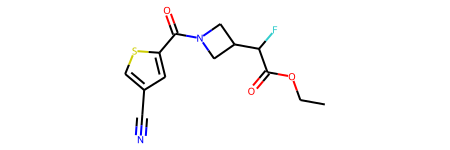

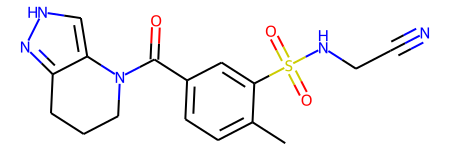

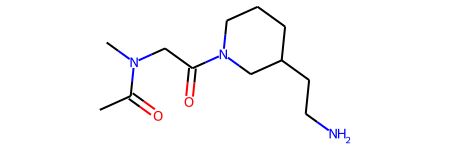

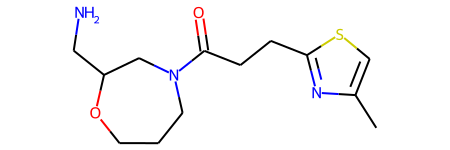

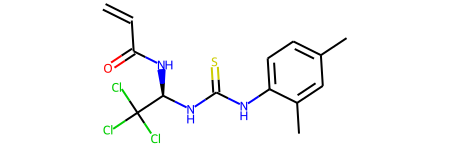

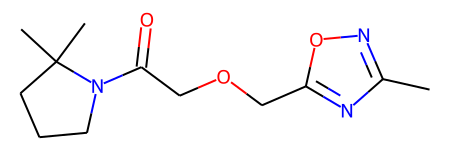

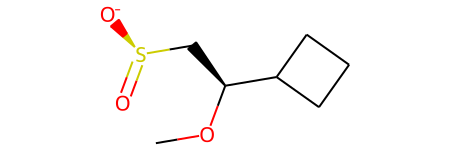

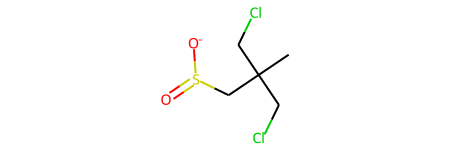

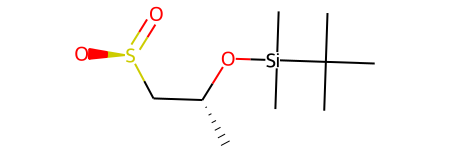

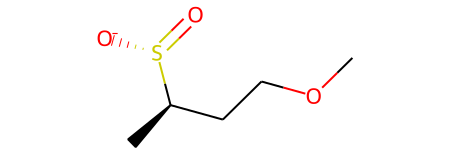

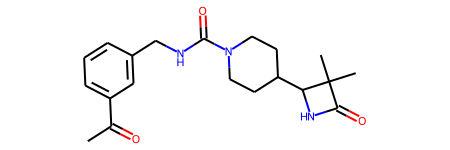

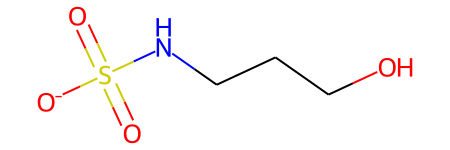

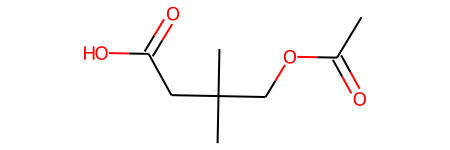

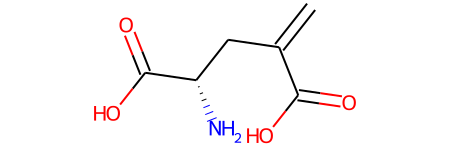

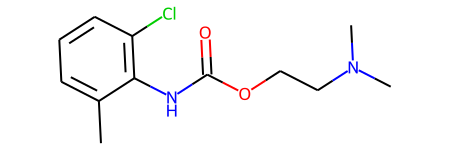

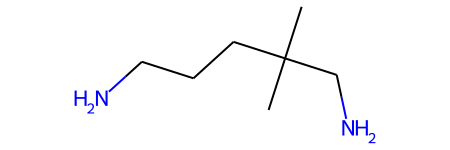

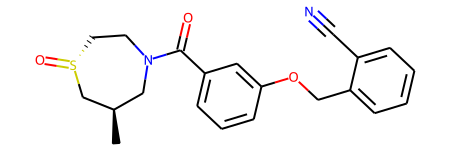

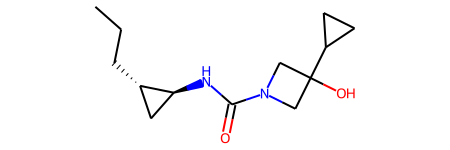

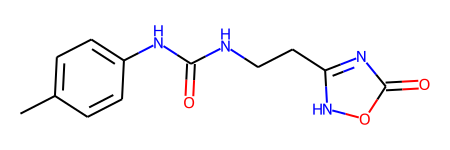

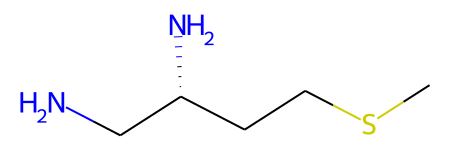

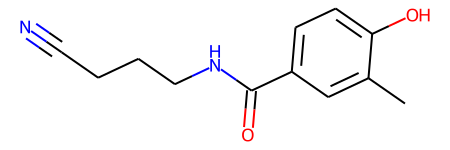

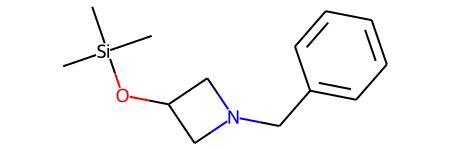

In [171]:
problem_solvents = ["Ammonia", "Di-2-butylamin", "H2SO4", "Formic-acid"]
for m in mol_df[(mol_df["g_soln_corr_lec_gas_abs"]>3) & (~mol_df["solvent"].isin(problem_solvents)) & (mol_df["n_rotatable_bonds"]==4)].mol_id.unique():
    smi = id_to_smi.loc[m]["canon_smi"]
    display(Chem.MolFromSmiles(smi))

### what if we use "relevant" gas-phase conformers for dG soln

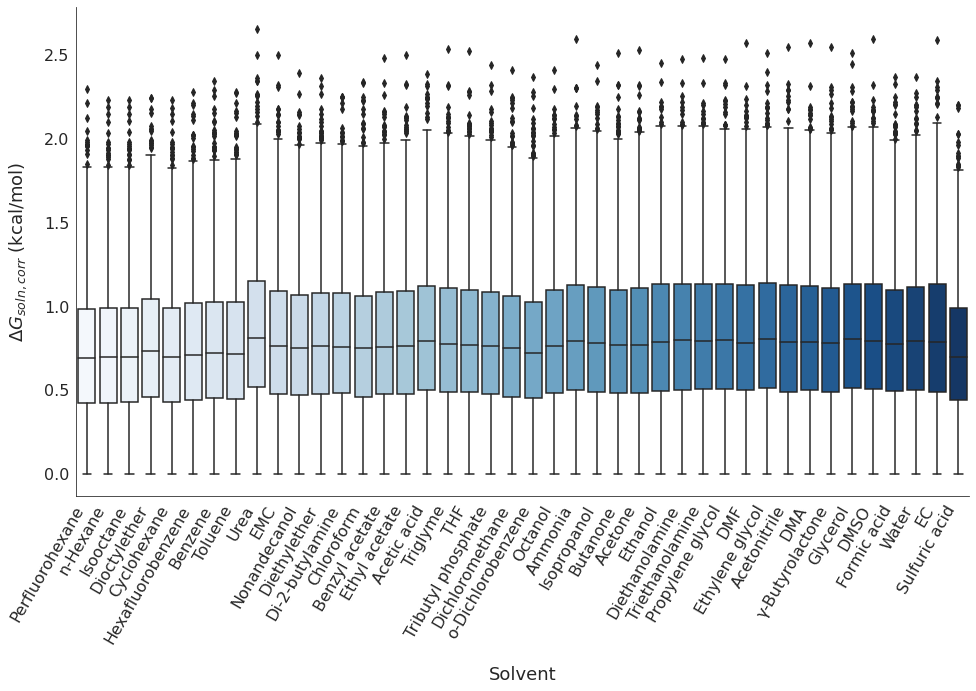

In [666]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

sns.boxplot(
    data=mol_df,
    x='solvent',
    y='corr_relevant_gas_confs_abs',
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=True,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

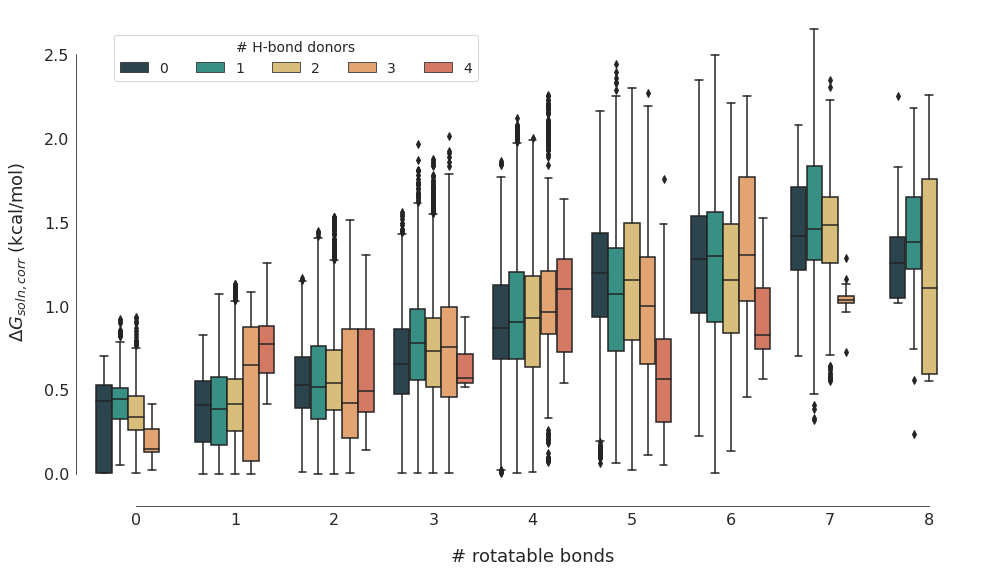

In [667]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds',
    y='corr_relevant_gas_confs_abs',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

sns.despine(offset=10, trim=True)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

# ax1.set_title("Effect of conformers on $\Delta G_{soln}$ in water", fontsize=22, pad=10)

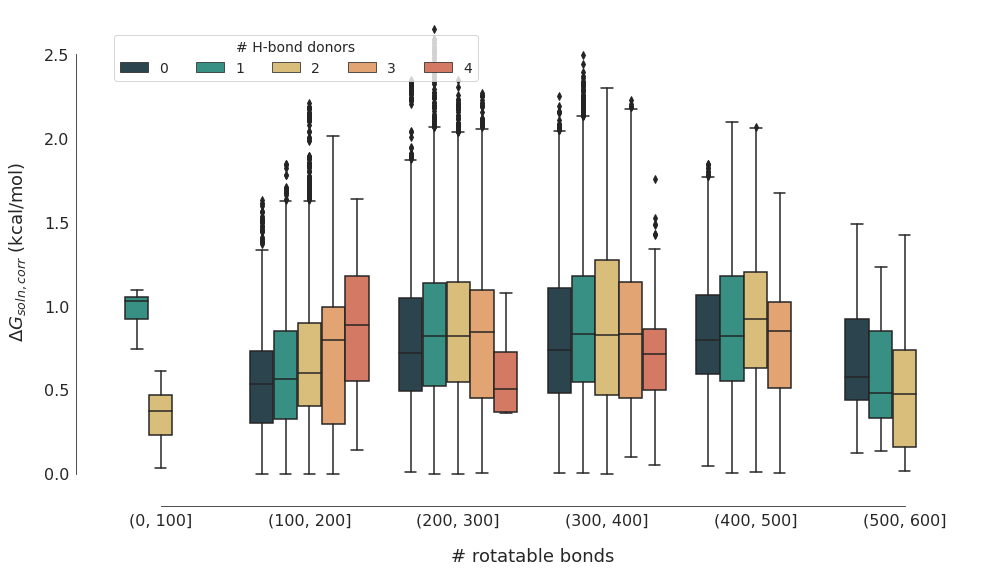

In [668]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[((mol_df["n_hbd"]<5))],
    x='mol_weight_binned',
    y='corr_relevant_gas_confs_abs',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

sns.despine(offset=10, trim=True)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

# ax1.set_title("Effect of conformers on $\Delta G_{soln}$ in water", fontsize=22, pad=10)

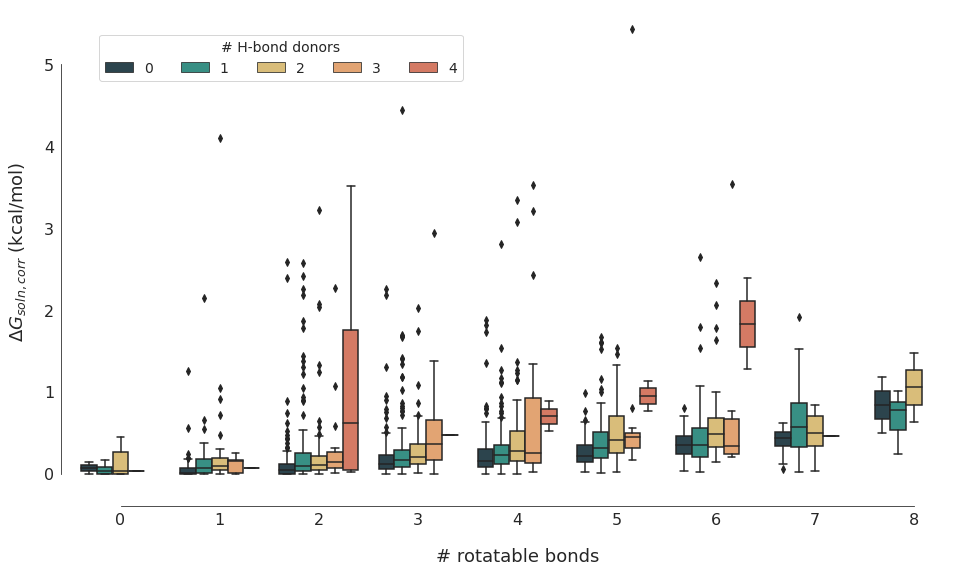

In [304]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[((mol_df["n_hbd"]<5)) & (mol_df["solvent"]=="H2O")],
    x='n_rotatable_bonds',
    y='corr_relevant_gas_confs_abs',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

sns.despine(offset=10, trim=True)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

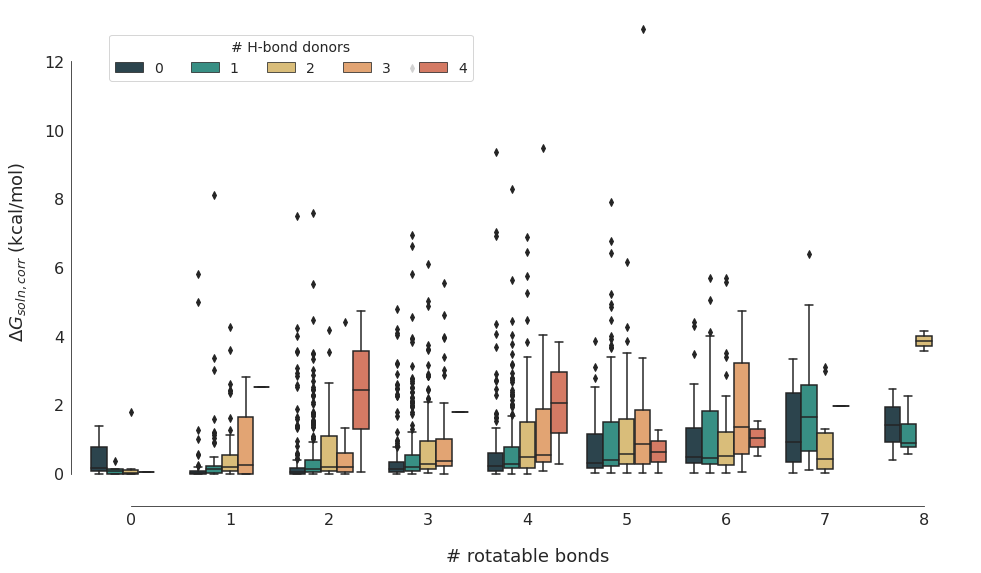

In [305]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[((mol_df["n_hbd"]<5)) & (mol_df["solvent"]=="H2SO4")],
    x='n_rotatable_bonds',
    y='corr_relevant_gas_confs_abs',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

sns.despine(offset=10, trim=True)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

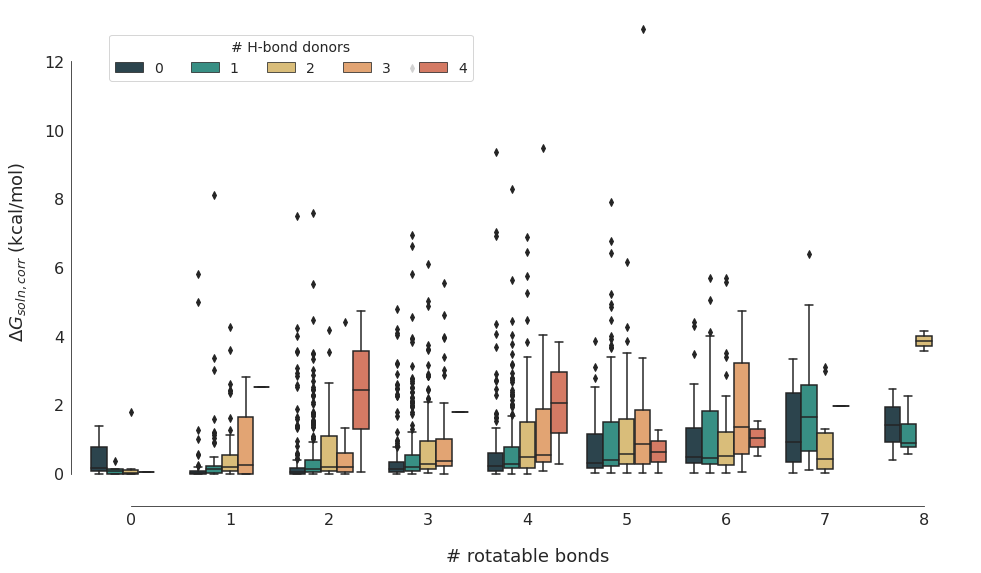

In [302]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[((mol_df["n_hbd"]<5)) & (mol_df["solvent"]=="H2SO4")],
    x='n_rotatable_bonds',
    y='corr_relevant_gas_confs_abs',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

sns.despine(offset=10, trim=True)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

In [294]:
pd.set_option('display.max_rows', 32)

mol_df["gas_confs_with_error"] = mol_df["corr_relevant_gas_confs_abs"]>3
mol_df.groupby("gas_confs_with_error")['n_rotatable_bonds'].mean()

gas_confs_with_error
False    3.396839
True     3.719444
Name: n_rotatable_bonds, dtype: float64

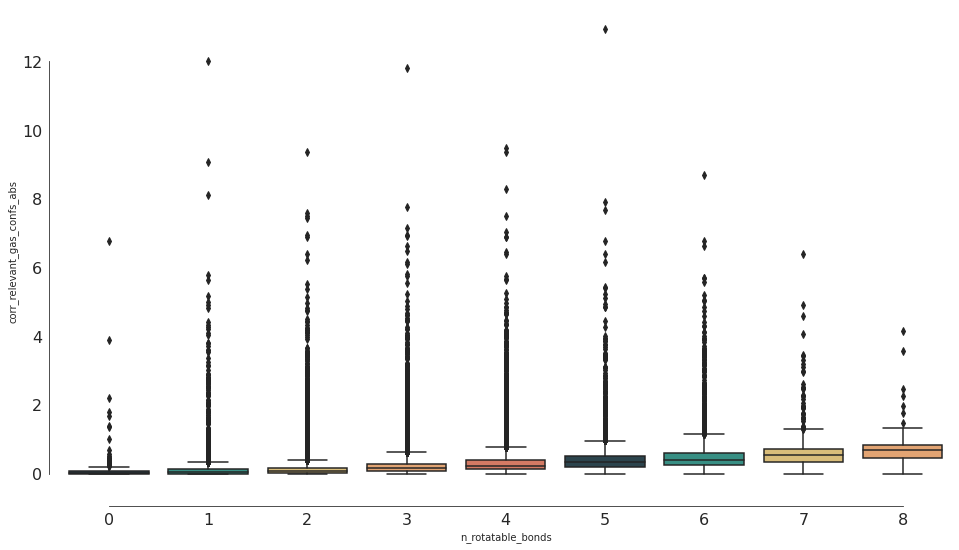

In [301]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["n_hbd"]<5)],
    x='n_rotatable_bonds',
    y='corr_relevant_gas_confs_abs',
    ax=ax1,
    palette=palette,
    showfliers=True,
#     cut=0,
)

sns.despine(offset=10, trim=True)

# ax1.set_yscale('log')
# ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
# ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

<AxesSubplot:xlabel='atom', ylabel='corr_relevant_gas_confs_abs'>

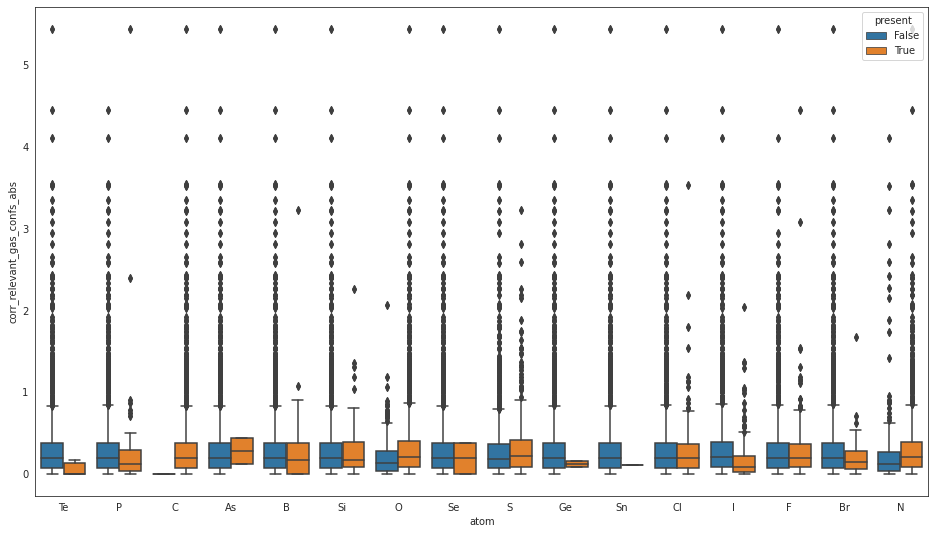

In [357]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

atom_df = mol_df.melt(id_vars=["mol_id", "solvent", "corr_relevant_gas_confs_abs"],
                      value_vars=list(unique_atoms), var_name="atom", value_name="present")

sns.boxplot(
    data=atom_df[atom_df["solvent"]=="H2O"],
    x="atom",
    hue="present",
    y="corr_relevant_gas_confs_abs",
    ax=ax1,
)

In [351]:
atom_df

mol_id          solvent  corr_relevant_gas_confs_abs atom  \
0        ct_ASTXFQ867JZC      Acetic-acid                     0.282622   Te   
1        ct_ASTXFQ867JZC           Aceton                     0.339605   Te   
2        ct_ASTXFQ867JZC     Acetonitrile                     0.326188   Te   
3        ct_ASTXFQ867JZC          Ammonia                     0.335027   Te   
4        ct_ASTXFQ867JZC          Benzene                     0.352988   Te   
...                  ...              ...                          ...  ...   
1438075  pka_extern_7111         Triglyme                     1.225005    N   
1438076  pka_extern_7111             Urea                     1.494427    N   
1438077  pka_extern_7111   g-Butyrolacton                     1.232201    N   
1438078  pka_extern_7111          n-Hexan                     1.037564    N   
1438079  pka_extern_7111  o-Dichlorbenzol                     1.262029    N   

         present  
0          False  
1          False  
2          False  
3          False  
4          False  
...          ...  
1438075     True  
1438076     True  
1438077     True  
1438078     True  
1438079     True  

[1438080 rows x 5 columns]

### how many conformers within 1 kcal/mol of true dG soln

In [483]:
# within 1 kcal of boltzmann averaged value
conf_df["within_1kcal_gsoln"] = np.abs(conf_df["g_soln_all_confs_diff"]) < 1
n_confs_within_1kcal_gsoln = \
    conf_df.groupby(["mol_id", "solvent"]).apply(lambda x: np.sum(x["within_1kcal_gsoln"]))
percent_confs_within_1kcal_gsoln = \
    conf_df.groupby(["mol_id", "solvent"])\
           .apply(lambda x: np.sum(x["within_1kcal_gsoln"]) / len(x["within_1kcal_gsoln"]))

mol_df["n_confs_within_1kcal_gsoln"] = \
    n_confs_within_1kcal_gsoln.reset_index().sort_values(["mol_id", "solvent"])[0].values
mol_df["percent_confs_within_1kcal_gsoln"] = \
    percent_confs_within_1kcal_gsoln.reset_index().sort_values(["mol_id", "solvent"])[0].values * 100.


# within 1 kcal of g_soln_0
conf_df["within_1kcal_gsoln0"] = np.abs(conf_df["g_soln_lec_conf_diff"]) < 1
n_confs_within_1kcal_gsoln0 = \
    conf_df.groupby(["mol_id", "solvent"]).apply(lambda x: np.sum(x["within_1kcal_gsoln0"]))
percent_confs_within_1kcal_gsoln0 = \
    conf_df.groupby(["mol_id", "solvent"])\
           .apply(lambda x: np.sum(x["within_1kcal_gsoln"]) / len(x["within_1kcal_gsoln0"]))

mol_df["n_confs_within_1kcal_gsoln0"] = \
    n_confs_within_1kcal_gsoln0.reset_index().sort_values(["mol_id", "solvent"])[0].values
mol_df["percent_confs_within_1kcal_gsoln0"] = \
    percent_confs_within_1kcal_gsoln0.reset_index().sort_values(["mol_id", "solvent"])[0].values * 100.

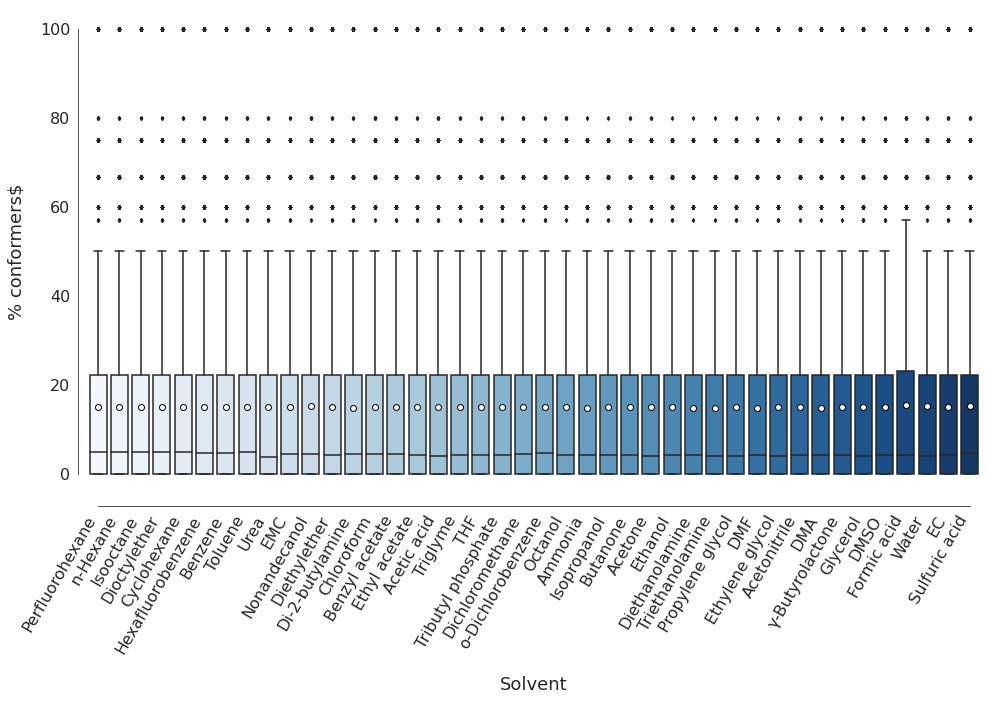

In [487]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

sns.boxplot(
    data=mol_df,
    x='solvent',
    y='percent_confs_within_1kcal_gsoln',
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=True,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"},
    flierprops={"marker":'d', "markersize":3},
)

sns.despine(offset=10, trim=True)
ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel(r"% conformers$", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

plt.savefig("../exps/plots/percent_confs_within_1kcal_gsoln_solvents.pdf", bbox_inches="tight")

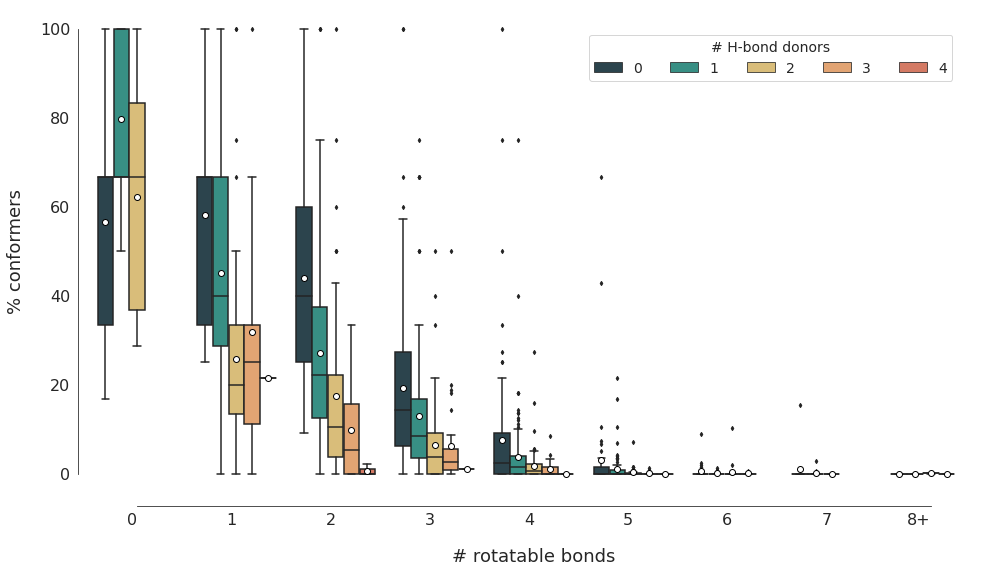

In [490]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="H2O") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds_binned',
    y='percent_confs_within_1kcal_gsoln',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"},
    flierprops={"marker":'d', "markersize":3},
)

sns.despine(offset=10, trim=True)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"% conformers", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
x_labels = [str(i) for i in range(8)] + ["8+"]
ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper right', borderaxespad=2)

plt.savefig("../exps/plots/percent_confs_within_1kcal_gsoln_water.pdf", bbox_inches="tight")

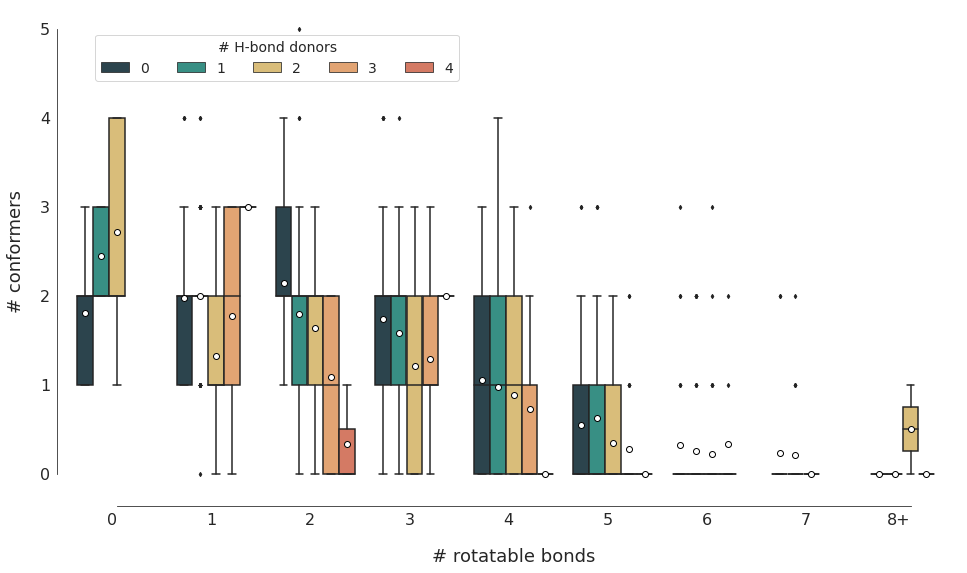

In [489]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="H2O") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds_binned',
    y='n_confs_within_1kcal_gsoln',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"},
    flierprops={"marker":'d', "markersize":3},
)

# ax1.set_ylim(0, 600)
sns.despine(offset=10, trim=True)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"# conformers", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
x_labels = [str(i) for i in range(8)] + ["8+"]
ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

plt.savefig("../exps/plots/n_confs_within_1kcal_gsoln_water.pdf", bbox_inches="tight")

Text(0.5, 1.0, '% conformers within 1 kcal/mol of $\\Delta G_{soln}$ in water')

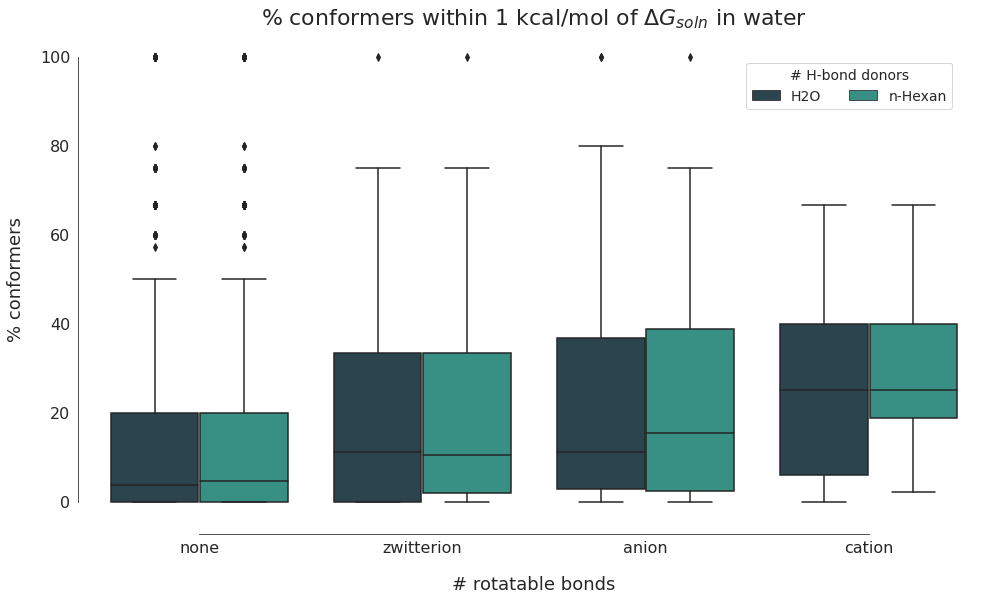

In [146]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"].isin(["H2O", "n-Hexan"])) & ((mol_df["n_hbd"]<5))],
    x='ion',
    y='percent_confs_within_1kcal_gsoln',
    hue="solvent",
    ax=ax1,
    palette=palette,
#     hue="ion",
    showfliers=True,
#     cut=0,
)

sns.despine(offset=10, trim=True)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"% conformers", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper right', borderaxespad=2)
ax1.set_title("% conformers within 1 kcal/mol of $\Delta G_{soln}$ in water", fontsize=22, pad=10)

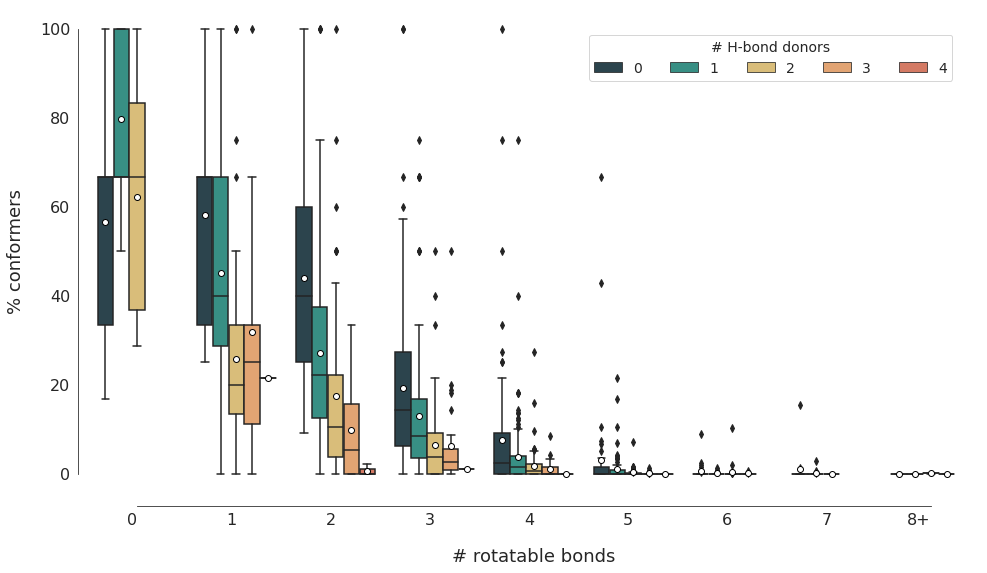

In [376]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="H2O") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds_binned',
    y='percent_confs_within_1kcal_gsoln0',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"}
)

sns.despine(offset=10, trim=True)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"% conformers", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
x_labels = [str(i) for i in range(8)] + ["8+"]
ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper right', borderaxespad=2)

# plt.savefig("../exps/plots/percent_confs_within_1kcal_gsoln_water.pdf", bbox_inches="tight")

### how do the relevant conformers change between solvents
use the Jaccard index to quantify difference in relevant conformers

In [48]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import jaccard, pdist, squareform

# def determine_conf_inclusion(df, threshold=1):
#     group = df["G(solution)_corr_confs"]
#     first_conf = np.argmax(group<threshold)+1
#     conf_included = [True] * first_conf + [False] * (len(group)-first_conf)
#     return pd.Series(conf_included)


# # determine which conformers are included in each solvent set of low-energy conformers
# out = conf_df.groupby(["mol_id", "solvent"]).apply(lambda x: determine_conf_inclusion(x, threshold=1))
# conf_df = conf_df.sort_values(["mol_id", "solvent"])
# conf_df["include_conf"] = out.reset_index().sort_values(["mol_id", "solvent"])[0].values

# find jaccard similarity between solvents
jaccard_sim = []
for i, df in tqdm(conf_df.groupby(["mol_id"])):
    n_confs = df.conf_id.nunique()
    if n_confs < 3:
        continue
    # jaccard_vals = 1 - squareform(pdist(df.pivot(index='conf_id', columns='solvent', values=['include_conf']).T.sort_values('solvent').values, jaccard))
    jaccard_vals = 1 - squareform(pdist(df.pivot(index='conf_id', columns='solvent', values=['within_1kcal_gsoln']).T.sort_values('solvent').values, jaccard))
    jaccard_sim.append(jaccard_vals)

/home/lagnajit/anaconda3/envs/ConfSolv/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


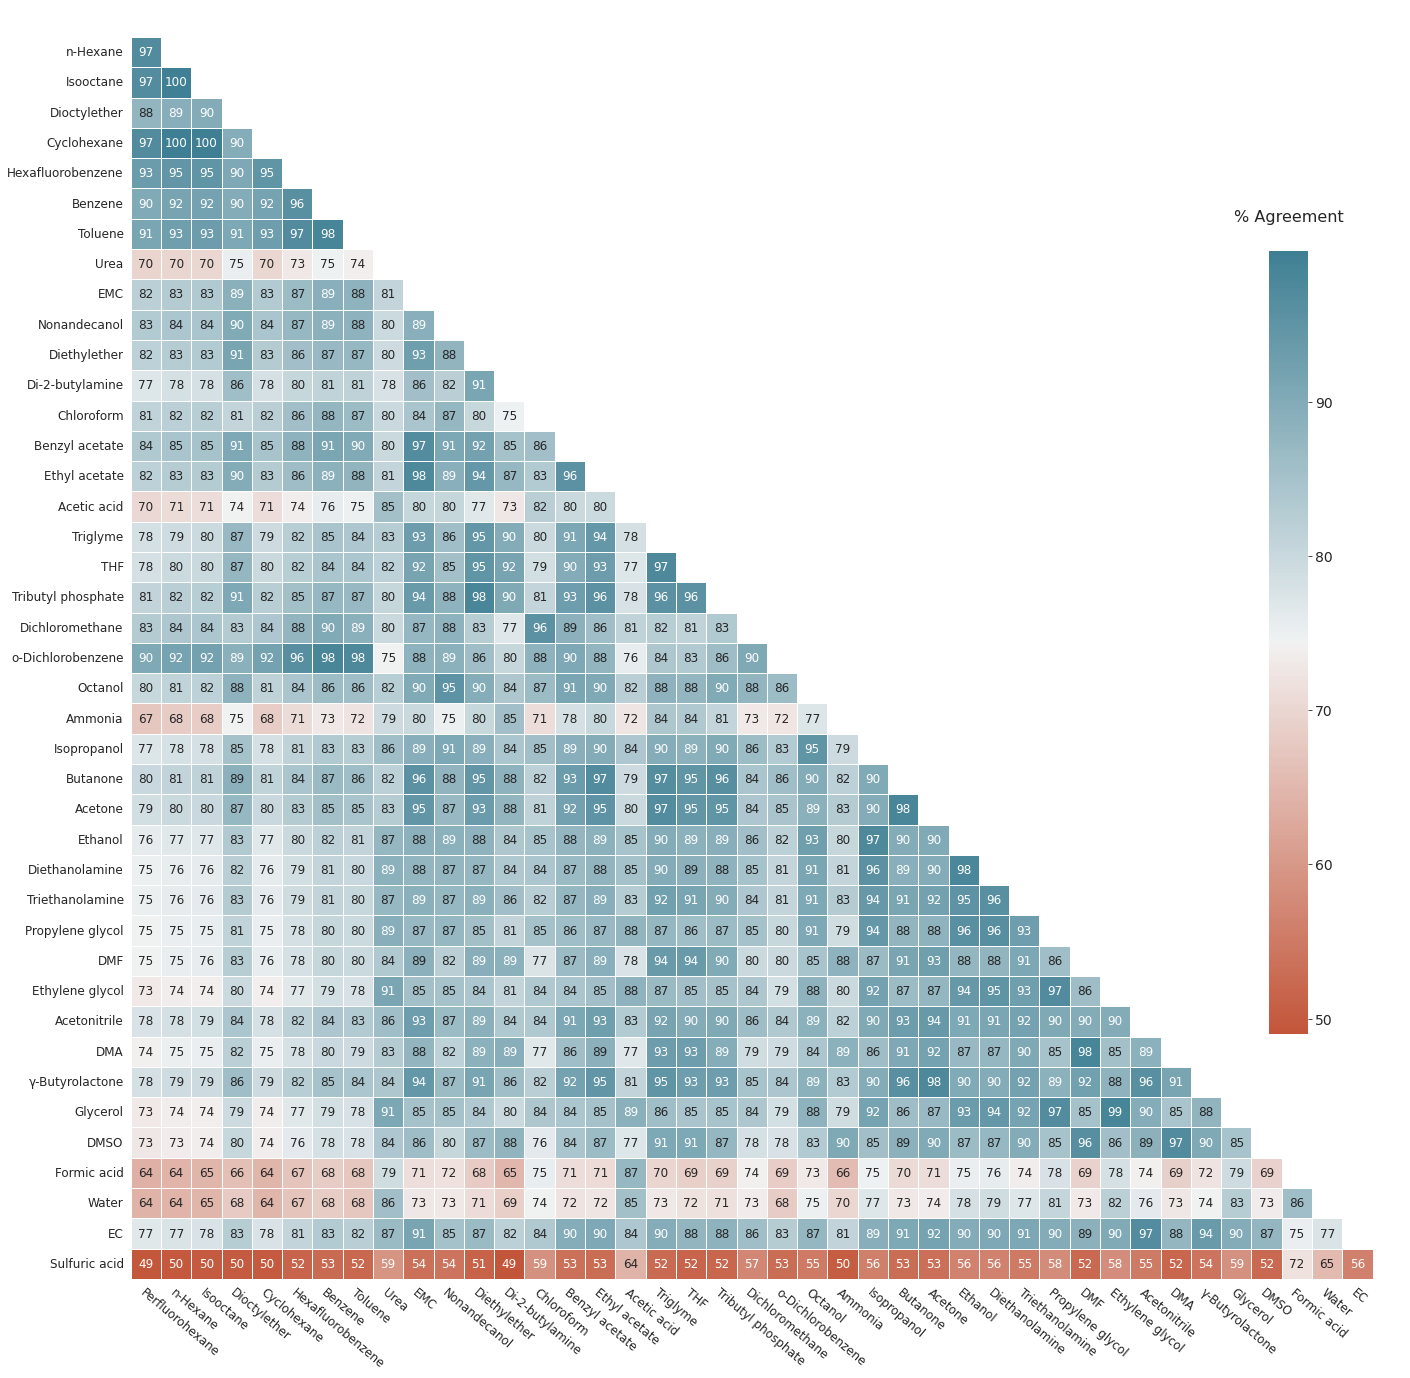

In [49]:
jaccard_sim_solvents = np.stack(jaccard_sim).mean(axis=0) * 100

ordered_dielectric = [dielectric_dict[s] for s in sorted(solvents)]
dielectric_order = np.argsort(ordered_dielectric)
ordered_names = [solvent_key_name_dict[sorted(solvents)[i]] for i in dielectric_order]
reshaped_jaccard_sim_solvents = jaccard_sim_solvents[dielectric_order][:, dielectric_order]

lower_triangular_heatmap(
    reshaped_jaccard_sim_solvents,
    ordered_names,
    ordered_names,
    hide_diags=True,
    annot_fmt=".0f",
)

# plt.savefig(f"../exps/plots/jaccard_sim.pdf", bbox_inches="tight")

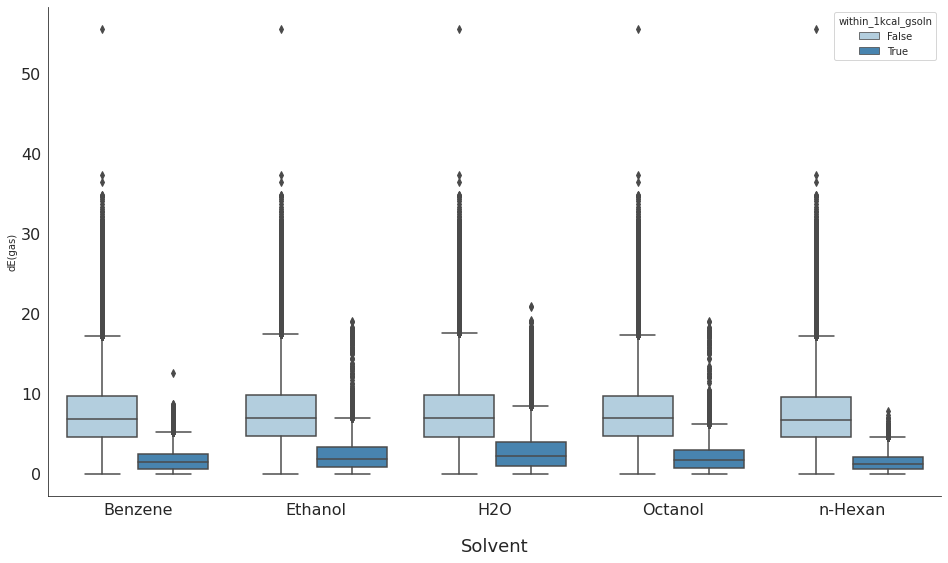

In [57]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

sns.boxplot(
    data=conf_df[conf_df["solvent"].isin(representative_solvents)],
    y="dE(gas)",
    x="solvent",
    hue="within_1kcal_gsoln",
    ax=ax1,
    palette="Blues",
#     order=ordered_solvents,
    showfliers=True,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
# ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

In [156]:
gas_1kcal_agreement = conf_df.groupby(['mol_id', 'solvent']).apply(lambda x: \
    len(set(x[x["within_1kcal_gsoln"]]["conf_id"]) & set(x[x["within_1kcal_egas"]]["conf_id"])) /\
    len(set(x[x["within_1kcal_egas"]]["conf_id"])))
mol_df["gas_1kcal_agreement"] = \
    gas_1kcal_agreement.reset_index().sort_values(["mol_id", "solvent"])[0].values

In [99]:
gas_1kcal_agreement_rev = conf_df.groupby(['mol_id', 'solvent']).apply(lambda x: \
    len(set(x[x["within_1kcal_gsoln"]]["conf_id"]) & set(x[x["within_1kcal_egas"]]["conf_id"])) /\
    len(set(x[x["within_1kcal_gsoln"]]["conf_id"])))
mol_df["gas_1kcal_agreement_rev"] = \
    gas_1kcal_agreement_rev.reset_index().sort_values(["mol_id", "solvent"])[0].values

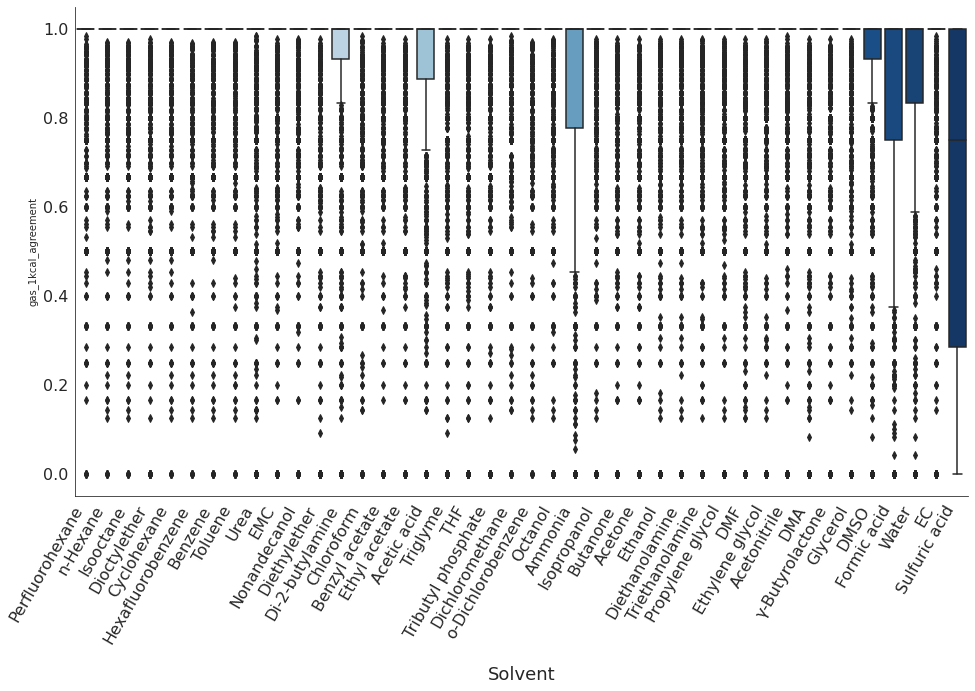

In [157]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

sns.boxplot(
    data=mol_df,
    y="gas_1kcal_agreement",
    x="solvent",
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=True,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
# ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

Text(0.5, 1.0, 'Effect of conformers on $\\Delta G_{soln}$ in water')

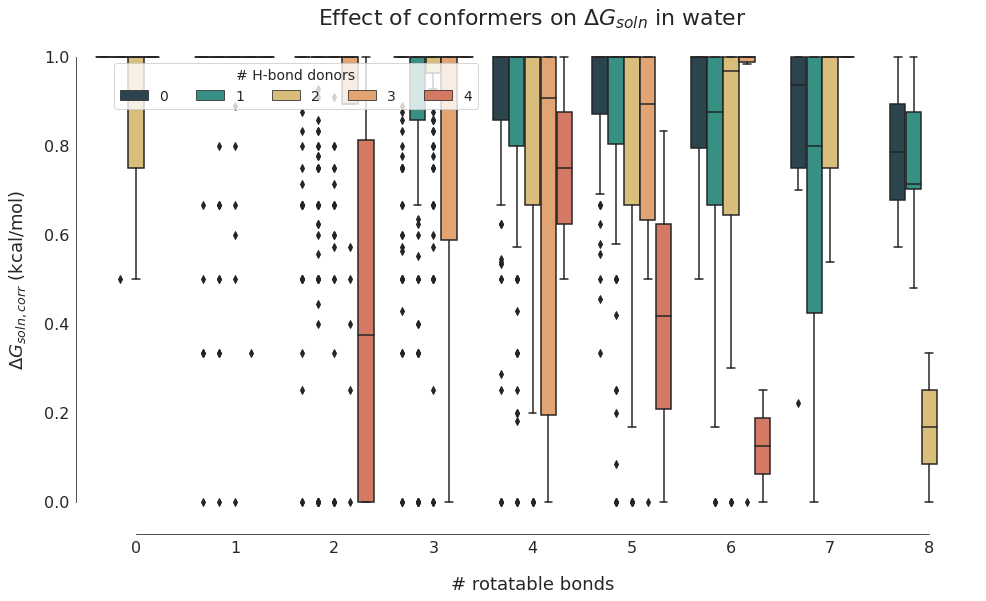

In [101]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="H2O") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds',
    y='gas_1kcal_agreement',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

sns.despine(offset=10, trim=True)
ax1.set_title("Effect of conformers on $\Delta G_{soln}$ in water", fontsize=22, pad=10)

# plt.savefig("../exps/plots/g_soln_corr_water.pdf", bbox_inches="tight")

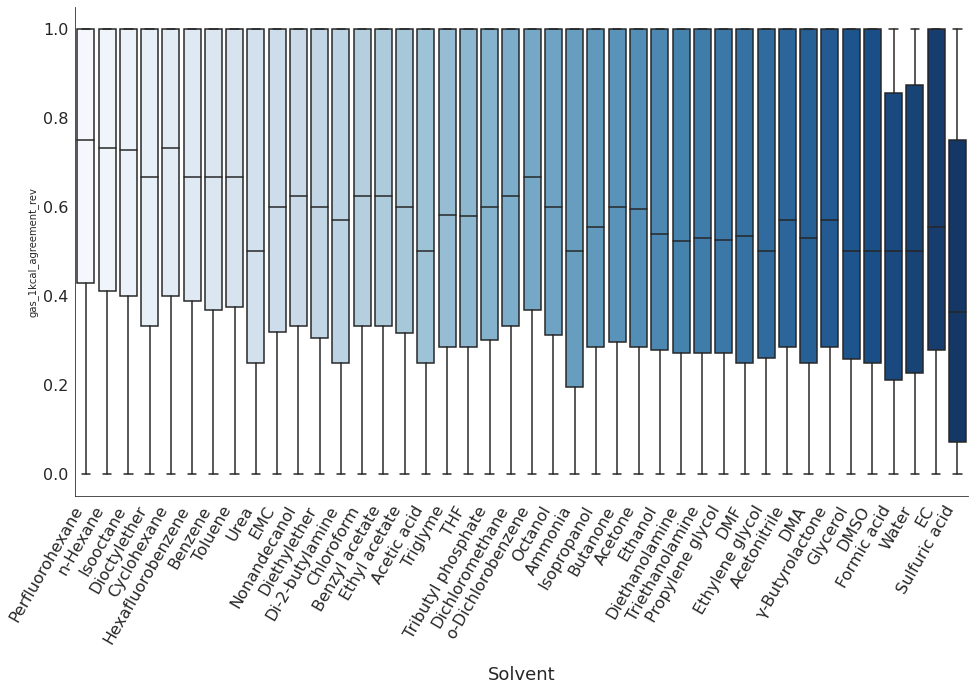

In [100]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

sns.boxplot(
    data=mol_df,
    y="gas_1kcal_agreement_rev",
    x="solvent",
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=True,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
# ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

### show an example of conformers considered vs distance from dG corr

/home/lagnajit/anaconda3/envs/ConfSolv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


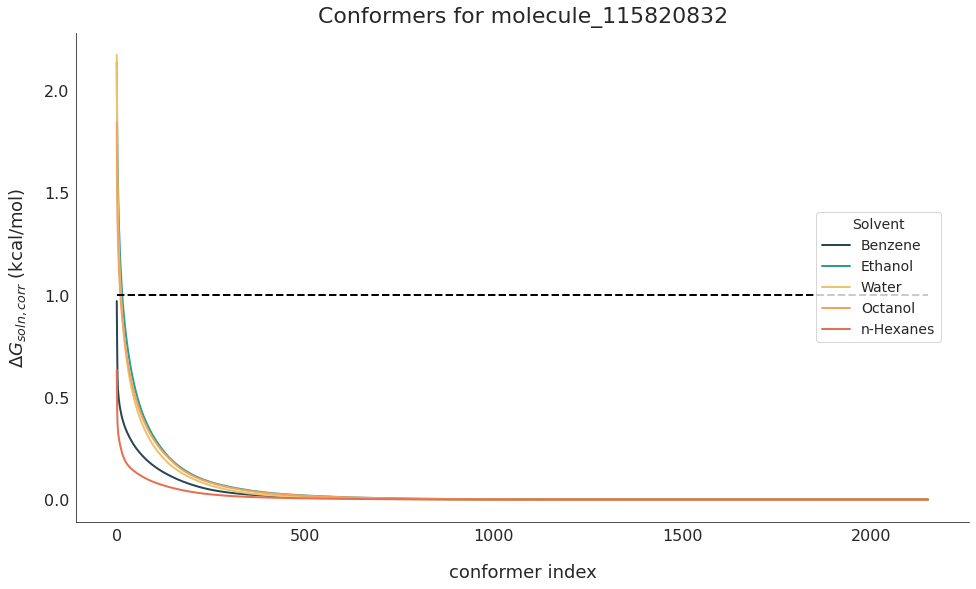

In [418]:
from pathlib import Path

# used mols: [-1, -100]

idx = np.argsort([len(x) for x in conf_dfs])[-10]
test_conf_df = conf_dfs[idx]
test_conf_solvents = test_conf_df[test_conf_df["solvent"].isin(representative_solvents)]
test_conf_solvents["g_soln_all_confs_cum_diff_abs"] = test_conf_solvents["g_soln_all_confs_cum_diff"].abs()
mol_id = test_conf_solvents["mol_id"].values[0]
smiles = id_to_smi.loc[mol_id]["canon_smi"]

n_confs = test_conf_solvents["conf_id"].nunique()
test_conf_solvents = test_conf_solvents.sort_values(["solvent", "dG(solution)"])
test_conf_solvents["conf_counter"] = (np.arange(n_confs).tolist() * 5)

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]


sns.lineplot(
    data=test_conf_solvents,
    y="g_soln_all_confs_cum_diff_abs",
    x="conf_counter",
    hue='solvent',
    palette=palette,
    linewidth=2,
    ax=ax1
)
ax1.hlines(y=1, xmin=0, xmax=n_confs, color="black", linestyle='--', linewidth=2)

ax1.set_xlabel("conformer index", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=1, fontsize=14, title="Solvent", title_fontsize=14, loc='center right', borderaxespad=2,
           labels=["Benzene", "Ethanol", "Water", "Octanol", "n-Hexanes"])
ax1.set_title(f"Conformers for {mol_id}", fontsize=22, pad=10)
#  sorted by increasing $\Delta G_{soln}$

plt_save_path = f"../exps/plots/conf_examples/{mol_id}/{mol_id}_confs.pdf"
if not os.path.exists(Path(plt_save_path).parent.absolute()):
    os.makedirs(Path(plt_save_path).parent.absolute())
# plt.savefig(f"../exps/plots/conf_examples/{mol_id}/{mol_id}_confs.pdf", bbox_inches="tight")

In [417]:
test_conf_df

mol_id    conf_id          solvent    dE(gas)    dG(gas)  \
2890    molecule_102375218  conf03694      Acetic-acid   0.000000   0.000000   
2891    molecule_102375218  conf03291      Acetic-acid   1.637669   1.518883   
2892    molecule_102375218  conf03435      Acetic-acid   2.170891   1.900576   
2893    molecule_102375218  conf03201      Acetic-acid   0.247132   0.241157   
2894    molecule_102375218  conf03436      Acetic-acid   1.343931   1.084609   
...                    ...        ...              ...        ...        ...   
121375  molecule_102375218  conf01982  o-Dichlorbenzol  10.880270  10.535862   
121376  molecule_102375218  conf04403  o-Dichlorbenzol  11.832470  11.545663   
121377  molecule_102375218  conf04404  o-Dichlorbenzol  11.883856  11.555940   
121378  molecule_102375218  conf01635  o-Dichlorbenzol  13.325063  12.255989   
121379  molecule_102375218  conf04316  o-Dichlorbenzol  13.415646  13.162060   

        dG(solution)         E(gas)         G(gas)    G(solution)  \
2890        0.000000 -385356.903684 -385217.274467 -385228.839728   
2891        0.055927 -385355.266015 -385215.755584 -385228.783801   
2892        0.080067 -385354.732554 -385215.373891 -385228.759661   
2893        0.126434 -385356.656313 -385217.033310 -385228.713294   
2894        0.157505 -385355.559514 -385216.189858 -385228.682223   
...              ...            ...            ...            ...   
121375     10.280843 -385346.023414 -385206.738604 -385215.772792   
121376     10.282038 -385345.071214 -385205.728804 -385215.771597   
121377     10.318845 -385345.019828 -385205.718527 -385215.734790   
121378     10.376924 -385343.578622 -385205.018478 -385215.676712   
121379     12.247862 -385343.487799 -385204.112406 -385213.805773   

        G(solvation)     G(RRHO)  G(gas+solvation)    G(gas+RRHO)  \
2890      -11.565261  139.629217    -385368.468945 -385217.274467   
2891      -13.028217  139.510431    -385368.294232 -385215.755584   
2892      -13.385770  139.358662    -385368.118324 -385215.373891   
2893      -11.679984  139.623003    -385368.336297 -385217.033310   
2894      -12.492605  139.369896    -385368.052119 -385216.189619   
...              ...         ...               ...            ...   
121375     -9.034188  139.284810    -385355.057602 -385206.738604   
121376    -10.042793  139.342410    -385355.114007 -385205.728804   
121377    -10.016263  139.301062    -385355.036091 -385205.718766   
121378    -10.658234  138.560143    -385354.236855 -385205.018478   
121379     -9.693366  139.375393    -385353.181166 -385204.112406   

        boltzmann_factor_pre  boltzmann_factor  g_soln_all_confs_diff  \
2890            1.000000e+00      1.700523e-02              -2.412703   
2891            9.098802e-01      1.547272e-02              -2.468630   
2892            8.735360e-01      1.485468e-02              -2.492770   
2893            8.077487e-01      1.373595e-02              -2.539137   
2894            7.664604e-01      1.303384e-02              -2.570208   
...                      ...               ...                    ...   
121375          2.885894e-08      1.731839e-09             -11.946801   
121376          2.880076e-08      1.728348e-09             -11.947996   
121377          2.706516e-08      1.624194e-09             -11.984803   
121378          2.453676e-08      1.472464e-09             -12.042881   
121379          1.041637e-09      6.250914e-11             -13.913820   

        g_soln_lec_conf_diff  g_soln_gas_solv_lec_rrho  \
2890                0.000000            -385228.839728   
2891               -0.055927            -385228.665015   
2892               -0.080067            -385228.489106   
2893               -0.126434            -385228.707080   
2894               -0.157505            -385228.422902   
...                      ...                       ...   
121375            -10.280843            -385215.428384   
121376            -10.282038            -385215.484790   
12

/home/lagnajit/anaconda3/envs/ConfSolv/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Conformers for epa_DTXCID30456516')

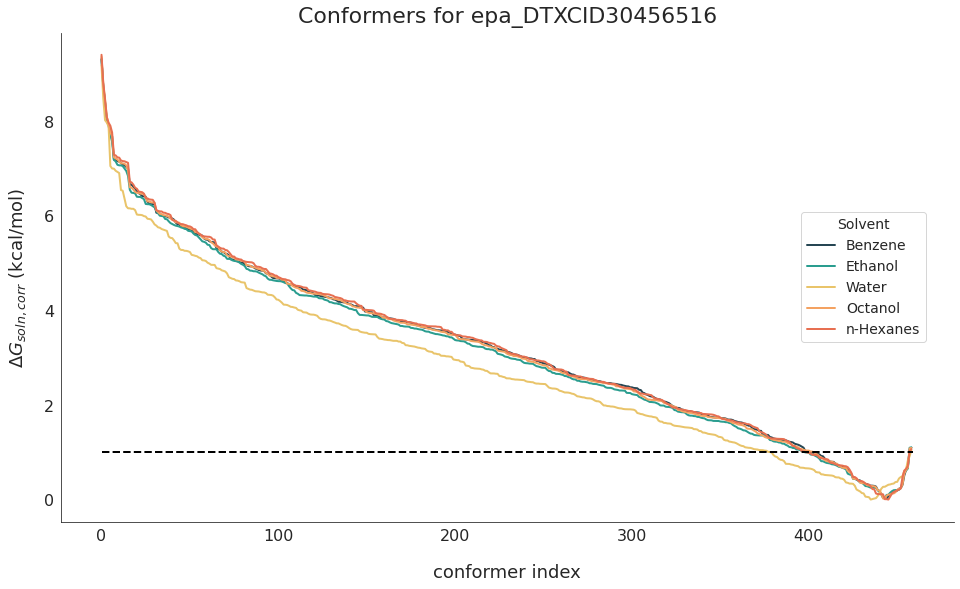

In [233]:
# show an example of conformers considered vs distance from dG corr

from pathlib import Path

# used mols: [-1, -100]

idx = np.argsort([len(x) for x in conf_dfs])[-100]
test_conf_df = conf_dfs[idx]
test_conf_solvents = test_conf_df[test_conf_df["solvent"].isin(representative_solvents)]
test_conf_solvents["G(solution)_corr_confs_rev_abs"] = test_conf_solvents["G(solution)_corr_confs_rev"].abs()
mol_id = test_conf_solvents["mol_id"].values[0]
smiles = id_to_smi.loc[mol_id]["canon_smi"]

n_confs = test_conf_solvents["conf_id"].nunique()
test_conf_solvents = test_conf_solvents.sort_values(["solvent", "dG(solution)"])
test_conf_solvents["conf_counter"] = (np.flip(np.arange(n_confs)).tolist() * 5)

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]


sns.lineplot(
    data=test_conf_solvents,
    y="G(solution)_corr_confs_rev_abs",
    x="conf_counter",
    hue='solvent',
    palette=palette,
    linewidth=2,
    ax=ax1
)
ax1.hlines(y=1, xmin=0, xmax=n_confs, color="black", linestyle='--', linewidth=2)

ax1.set_xlabel("conformer index", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{soln, corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=1, fontsize=14, title="Solvent", title_fontsize=14, loc='center right', borderaxespad=2,
           labels=["Benzene", "Ethanol", "Water", "Octanol", "n-Hexanes"])
ax1.set_title(f"Conformers for {mol_id}", fontsize=22, pad=10)

In [ ]:
# # write mols to file

from rdkit import Chem
# from rdmc import RDKitMol

import tempfile
from shutil import rmtree
from ase import io
import os
from glob import glob

temp_dir = tempfile.mkdtemp()
mol_id = test_conf_solvents["mol_id"].values[0]
test_coords_df = coords_df[coords_df["mol_id"]==mol_id]
conf_ids = test_conf_solvents[test_conf_solvents["solvent"]=="H2O"].sort_values("dG(solution)")["conf_id"].values

for i, m in enumerate(test_coords_df.set_index("conf_id").loc[conf_ids]["mol"]):
    mol_path = os.path.join(temp_dir, f"conf_{i}.xyz")
    io.write(mol_path, m)
    
# confs = []
# for xyz_file in glob(os.path.join(temp_dir, "conf_*")):
#     conf = RDKitMol.FromFile(xyz_file, sameMol=True)
#     confs.append(conf)
    
# ts_path = os.path.join("../../../conf_solv/exps/plots/", f"{mol_id}.sdf")
# ts_writer = Chem.rdmolfiles.SDWriter(ts_path)
# for c in confs:
#     ts_writer.write(c.ToRWMol(), confId=0)

# rmtree(temp_dir)

### conformers needed for x kcal/mol within dG soln

In [440]:
mol_df = mol_df.sort_values(["mol_id", "solvent"])
n_confs_needed_for_1kcal_gsoln = \
    conf_df.groupby(["mol_id", "solvent"]).apply(lambda x: np.argmax(x["g_soln_all_confs_cum_diff"].abs()<1)+1)
percent_confs_needed_for_1kcal_gsoln = \
    conf_df.groupby(["mol_id", "solvent"]).apply(lambda x: \
    (np.argmax(x["g_soln_all_confs_cum_diff"].abs()<1)+1)/len(x))

mol_df["n_confs_needed_for_1kcal_gsoln"] = \
    n_confs_needed_for_1kcal_gsoln.reset_index().sort_values(["mol_id", "solvent"])[0].values
mol_df["percent_confs_needed_for_1kcal_gsoln"] = \
    percent_confs_needed_for_1kcal_gsoln.reset_index().sort_values(["mol_id", "solvent"])[0].values * 100.

# percent_confs_needed_for_half_kcal_gsoln = \
#     conf_df.groupby(["mol_id", "solvent"]).apply(lambda x: \
#     (np.argmax(x["G(solution)_corr_confs"]<0.5)+1)/len(x["G(solution)_corr_confs"]))

# mol_df = mol_df.sort_values(["mol_id", "solvent"])
# mol_df["percent_confs_needed_for_half_kcal_gsoln"] = \
#     percent_confs_needed_for_half_kcal_gsoln.reset_index().sort_values(["mol_id", "solvent"])[0].values * 100.

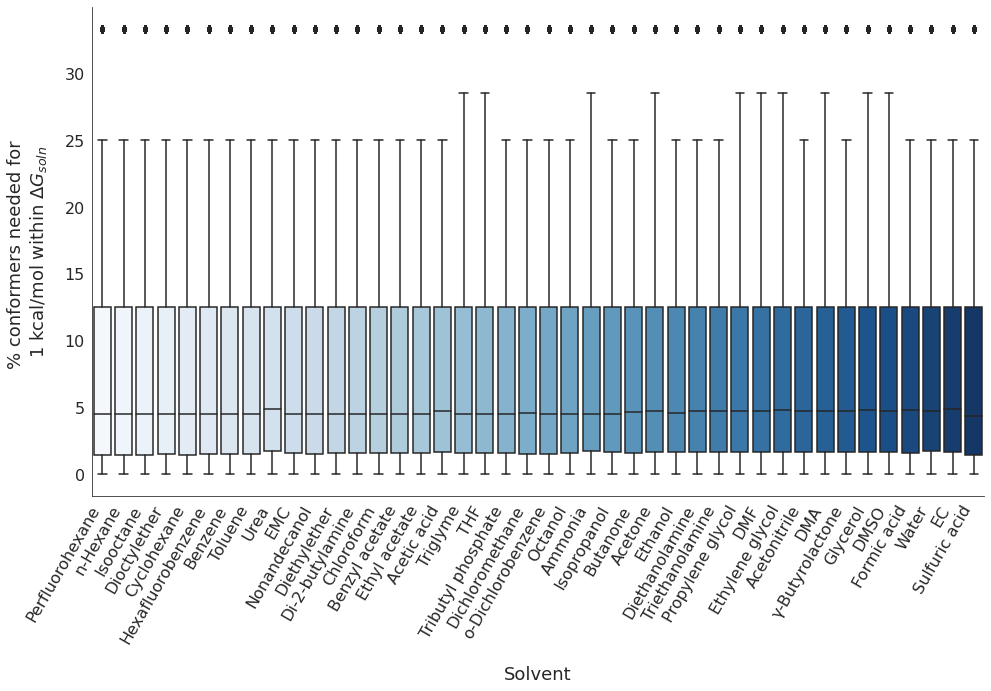

In [441]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

sns.boxplot(
    data=mol_df,
    x='solvent',
    y='percent_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=True,
#     cut=0,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed for \n1 kcal/mol within $\Delta G_{soln}$", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

# plt.savefig("../exps/plots/percent_confs_needed_per_solvent.pdf", bbox_inches="tight")

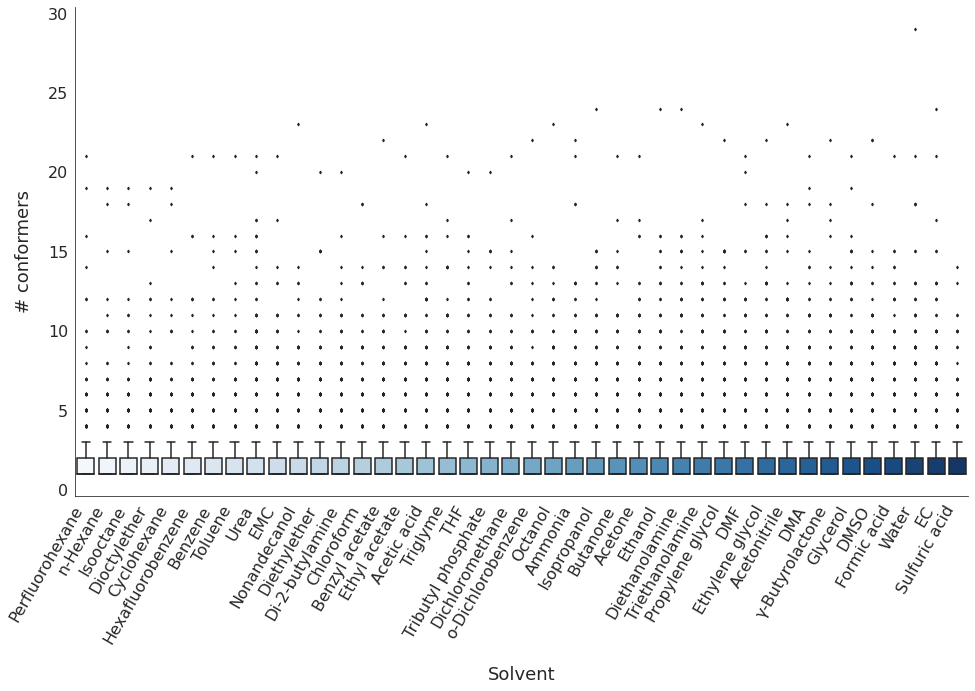

In [504]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

ordered_solvents = [solvent_keys[i] for i in np.argsort(dielctric_constants).tolist()]
ordered_solvent_names = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]

sns.boxplot(
    data=mol_df,
    x='solvent',
    y='n_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette="Blues",
    order=ordered_solvents,
    showfliers=True,
#     cut=0,
    flierprops={"marker":'d', "markersize":2},
)

# ax1.set_ylim(0, 23)
ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("# conformers", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

plt.savefig("../exps/plots/n_confs_needed_1kcal_gsoln_solvents.pdf", bbox_inches="tight")

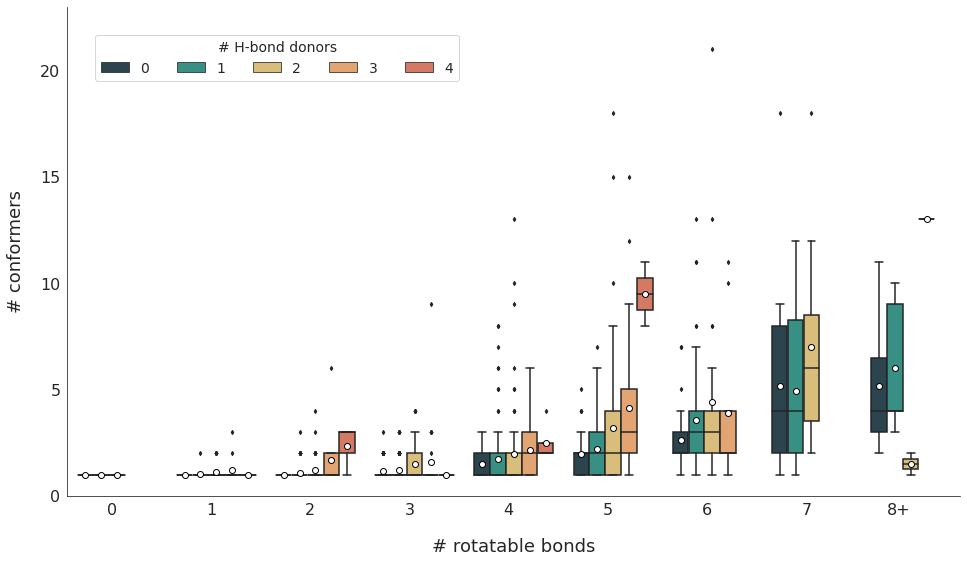

In [505]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="H2O") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds_binned',
    y='n_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"},
    flierprops={"marker":'d', "markersize":3},
#     cut=0,
)

ax1.set_ylim(0, 23)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel("# conformers", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
x_labels = [str(i) for i in range(8)] + ["8+"]
ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

plt.savefig("../exps/plots/n_confs_needed_1kcal_gsoln_water.pdf", bbox_inches="tight")

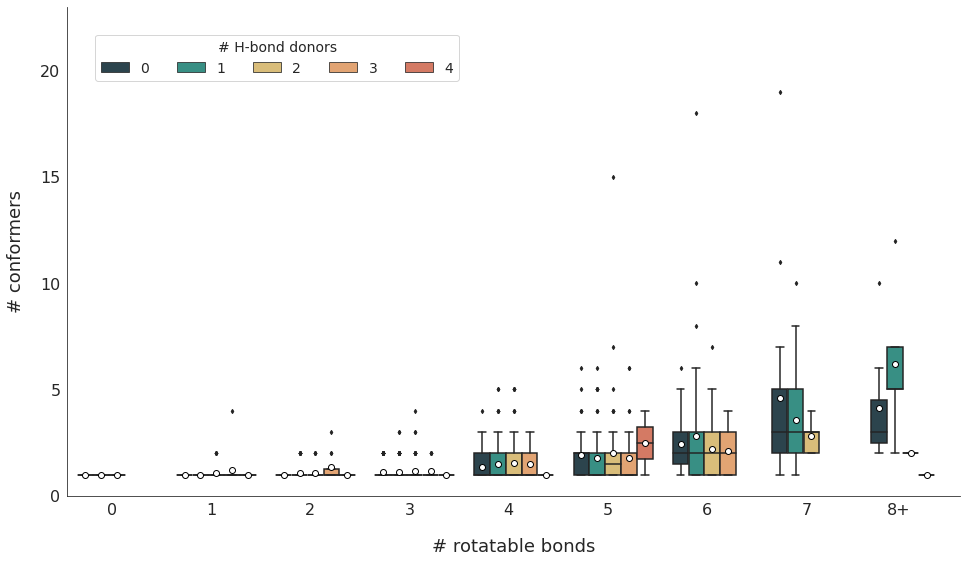

In [506]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="n-Hexan") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds_binned',
    y='n_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"},
    flierprops={"marker":'d', "markersize":3},
#     cut=0,
)

ax1.set_ylim(0, 23)
ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel("# conformers", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
x_labels = [str(i) for i in range(8)] + ["8+"]
ax1.set_xticklabels(labels=x_labels, fontsize=16, rotation=0, rotation_mode="default", ha="right")
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper left', borderaxespad=2)

plt.savefig("../exps/plots/n_confs_needed_1kcal_gsoln_hexane.pdf", bbox_inches="tight")

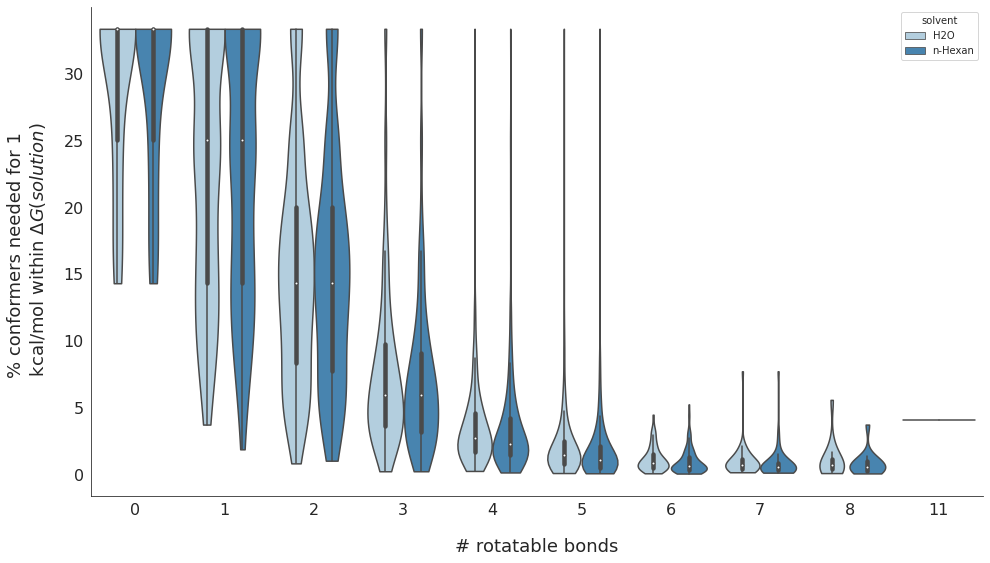

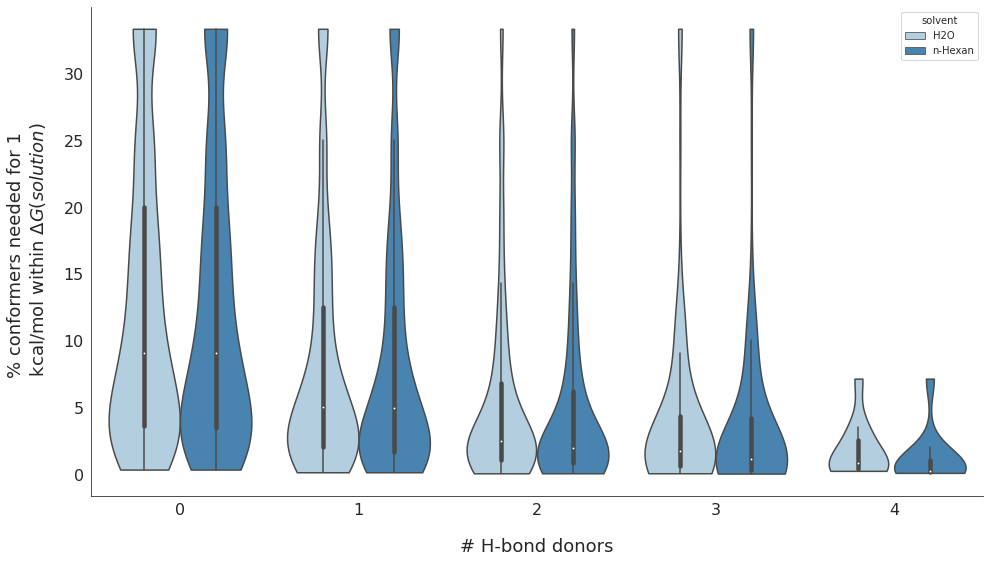

In [427]:
# test solute-level features with water and n-hexanes

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.violinplot(
    data=mol_df[(mol_df["solvent"]=="H2O") | (mol_df["solvent"]=="n-Hexan")],
    x='n_rotatable_bonds',
    y='percent_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette="Blues",
    hue="solvent",
    showfliers=True,
    cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed for 1 \n kcal/mol within $\Delta G(solution)$", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)




fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.violinplot(
    data=mol_df[(mol_df["solvent"]=="H2O") | (mol_df["solvent"]=="n-Hexan")],
    x='n_hbd',
    y='percent_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette="Blues",
    hue="solvent",
    showfliers=True,
    cut=0,
)

ax1.set_xlabel("# H-bond donors", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed for 1 \n kcal/mol within $\Delta G(solution)$", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

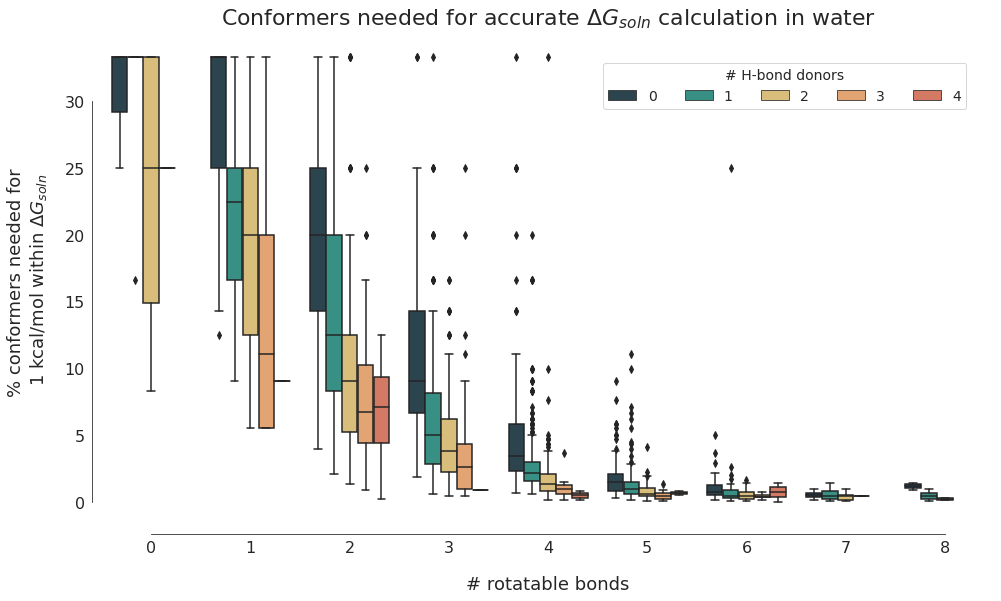

In [72]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="H2O") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds',
    y='percent_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed for \n1 kcal/mol within $\Delta G_{soln}$", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper right', borderaxespad=2)

sns.despine(offset=10, trim=True)
ax1.set_title("Conformers needed for accurate $\Delta G_{soln}$ calculation in water", fontsize=22, pad=10)

sns.despine(offset=10, trim=True)

# plt.savefig("../exps/plots/percent_confs_needed_water.pdf", bbox_inches="tight")

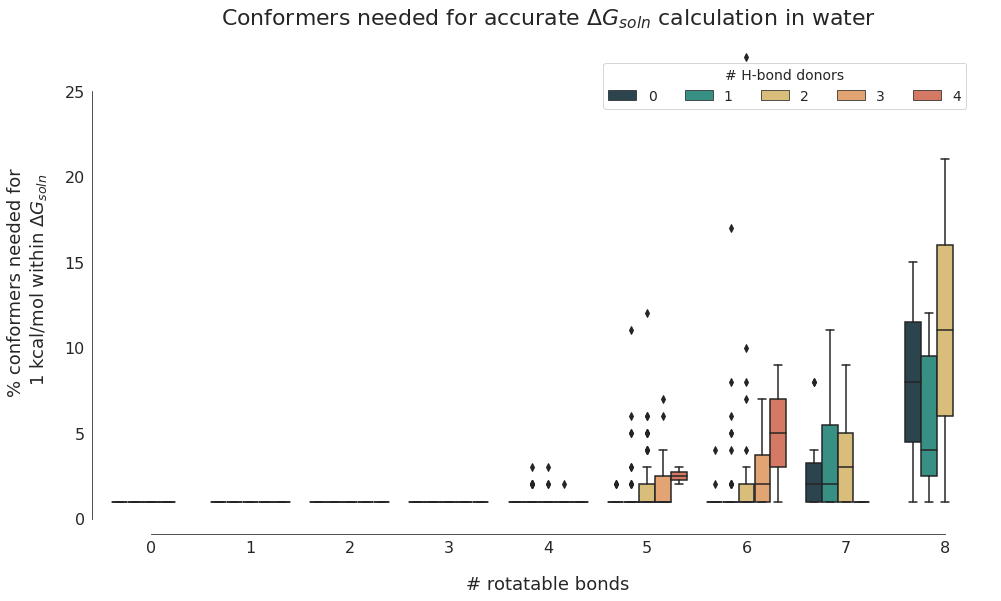

In [82]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="H2O") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds',
    y='n_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed for \n1 kcal/mol within $\Delta G_{soln}$", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper right', borderaxespad=2)

sns.despine(offset=10, trim=True)
ax1.set_title("Conformers needed for accurate $\Delta G_{soln}$ calculation in water", fontsize=22, pad=10)

sns.despine(offset=10, trim=True)

# plt.savefig("../exps/plots/percent_confs_needed_water.pdf", bbox_inches="tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="H2O") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds',
    y='n_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed for \n1 kcal/mol within $\Delta G_{soln}$", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper right', borderaxespad=2)

sns.despine(offset=10, trim=True)
ax1.set_title("Conformers needed for accurate $\Delta G_{soln}$ calculation in water", fontsize=22, pad=10)

sns.despine(offset=10, trim=True)

# plt.savefig("../exps/plots/percent_confs_needed_water.pdf", bbox_inches="tight")

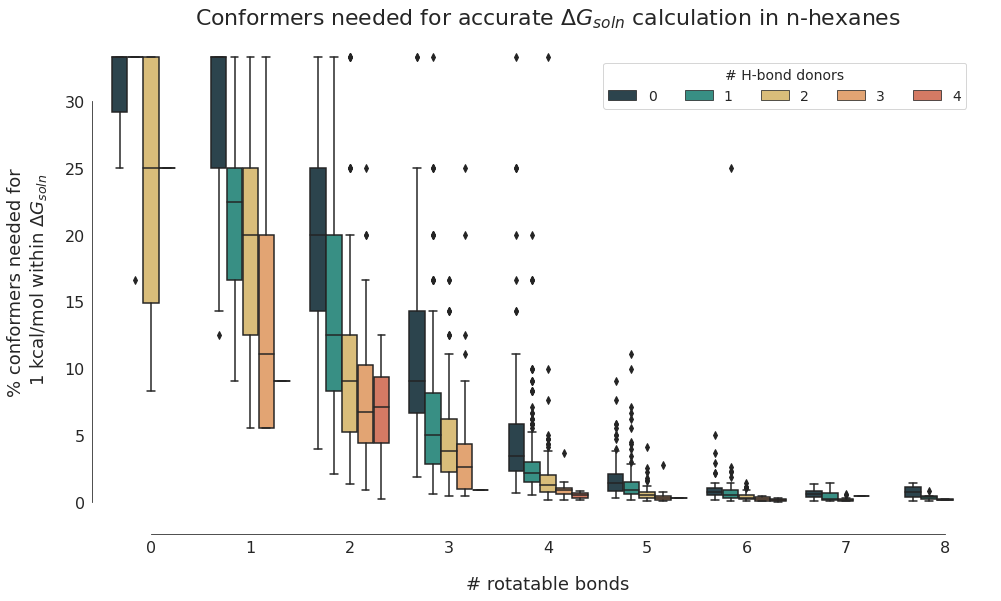

In [71]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="n-Hexan") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds',
    y='percent_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed for \n1 kcal/mol within $\Delta G_{soln}$", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper right', borderaxespad=2)

sns.despine(offset=10, trim=True)
ax1.set_title("Conformers needed for accurate $\Delta G_{soln}$ calculation in n-hexanes", fontsize=22, pad=10)

sns.despine(offset=10, trim=True)

# plt.savefig("../exps/plots/percent_confs_needed_hexanes.pdf", bbox_inches="tight")

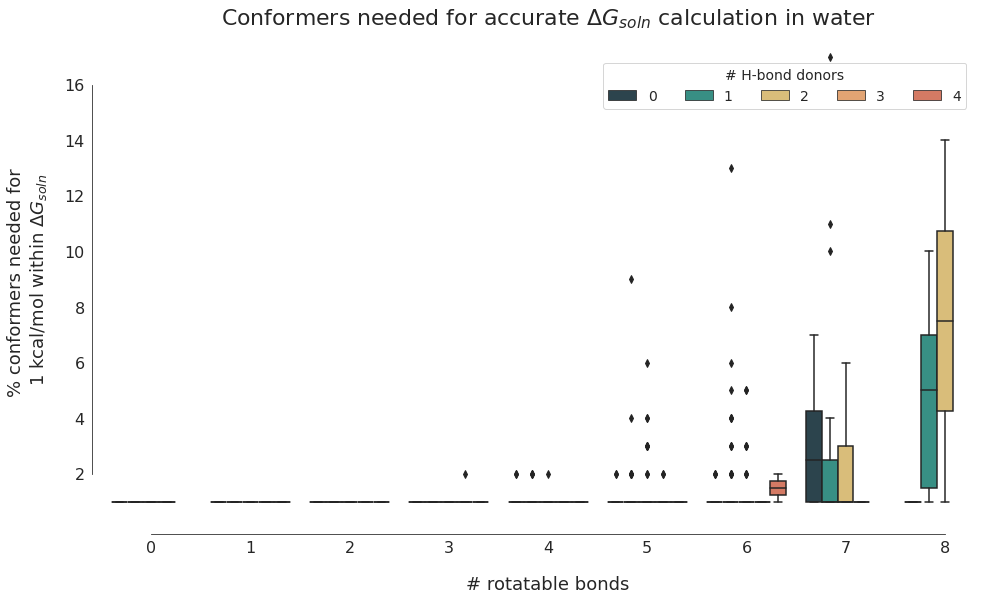

In [103]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")
palette = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51"]

sns.boxplot(
    data=mol_df[(mol_df["solvent"]=="n-Hexan") & ((mol_df["n_hbd"]<5))],
    x='n_rotatable_bonds',
    y='n_confs_needed_for_1kcal_gsoln',
    ax=ax1,
    palette=palette,
    hue="n_hbd",
    showfliers=True,
#     cut=0,
)

ax1.set_xlabel("# rotatable bonds", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed for \n1 kcal/mol within $\Delta G_{soln}$", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xticklabels(labels=ordered_solvent_names, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(ncol=5, fontsize=14, title="# H-bond donors", 
           title_fontsize=14, loc='upper right', borderaxespad=2)

sns.despine(offset=10, trim=True)
ax1.set_title("Conformers needed for accurate $\Delta G_{soln}$ calculation in water", fontsize=22, pad=10)

sns.despine(offset=10, trim=True)

# plt.savefig("../exps/plots/percent_confs_needed_water.pdf", bbox_inches="tight")

### relative ranges of all components used to calculate dG soln

In [196]:
relative_components_df = pd.concat(relative_components_list)
relative_components_df = add_mol_properties(relative_components_df)

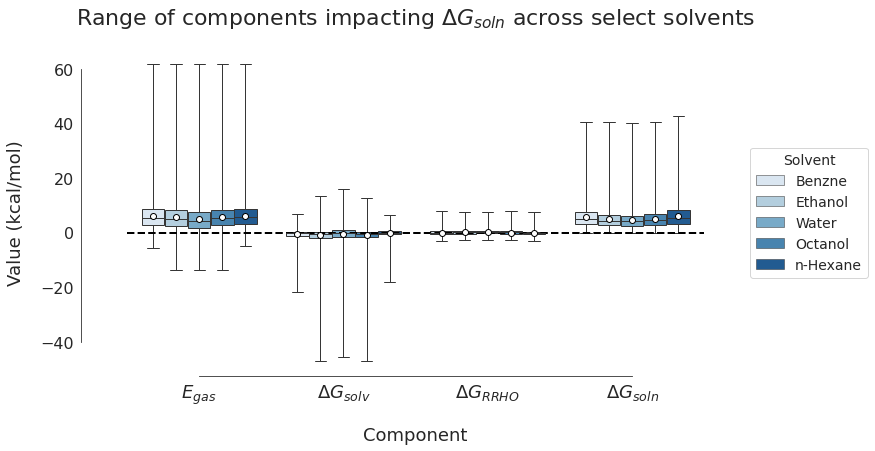

In [202]:
fig, ax1 = plt.subplots(figsize=(12, 6))

relative_components_solv = relative_components_df[relative_components_df["solvent"].isin(representative_solvents)]
sns.boxplot(
    data=relative_components_solv.melt(id_vars="solvent", \
                                       value_vars=["E(gas)", "G(solvation)", "G(RRHO)", "G(solution)"]),
    x='variable',
    y='value',
    hue='solvent',
    palette="Blues",
    showfliers=True,
    linewidth=1,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"},
    whis=99,
)

sns.despine(offset=0, trim=True)
ax1.hlines(0, -0.5, 3.5, linewidth=2, linestyle="--", color='black')

ax1.set_xlabel("Component", fontsize=18, labelpad=20)
ax1.set_ylabel("Value (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
handles = ax1.get_legend().legendHandles
ax1.legend(handles=handles, ncol=1, fontsize=14, title="Solvent",  title_fontsize=14, borderaxespad=2,
           labels=["Benzne", "Ethanol", "Water", "Octanol", "n-Hexane"], loc=(1.0, 0.3),)
ax1.set_xticklabels(["$E_{gas}$", "$\Delta G_{solv}$", "$\Delta G_{RRHO}$", "$\Delta G_{soln}$"], \
                     fontsize=18)

ax1.set_title("Range of components impacting $\Delta G_{soln}$ across select solvents", fontsize=22, pad=25)

plt.savefig("../exps/plots/g_soln_components_solvents.pdf", bbox_inches="tight")

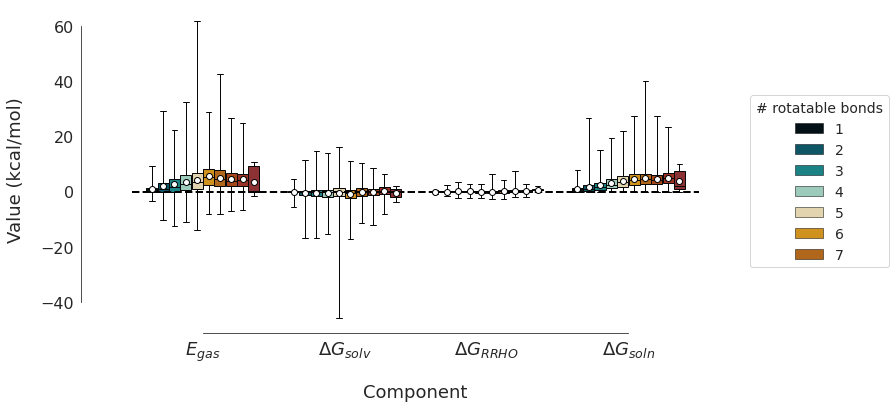

In [204]:
fig, ax1 = plt.subplots(figsize=(12, 6))

palette = ["#001219","#005f73","#0a9396","#94d2bd","#e9d8a6","#ee9b00","#ca6702","#bb3e03","#ae2012","#9b2226"]
relative_components_water = relative_components_df[relative_components_df["solvent"]=="H2O"]

sns.boxplot(
    data=relative_components_water.melt(id_vars=["solvent", 'n_rotatable_bonds', 'num_rings', 'n_hbd', 'n_hba', \
                                                 'mol_weight', 'mol_weight_binned', 'n_rotatable_bonds_binned'], \
                                        value_vars=["E(gas)", "G(solvation)", "G(RRHO)", "G(solution)"]),
    x='variable',
    y='value',
    hue='n_rotatable_bonds',
    palette=palette,
    showfliers=True,
    linewidth=1,
    showmeans=True,
    meanprops={"marker":"o",
               "markerfacecolor":"white", 
               "markeredgecolor":"black",
               "markersize":"6"},
    whis=99,
)

sns.despine(offset=0, trim=True)
ax1.hlines(0, -0.5, 3.5, linewidth=2, linestyle="--", color='black')

ax1.set_xlabel("Component", fontsize=18, labelpad=20)
ax1.set_ylabel("Value (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
handles = ax1.get_legend().legendHandles
ax1.legend(handles=handles, ncol=1, fontsize=14, title="# rotatable bonds",  title_fontsize=14, borderaxespad=2,
           labels=['1', '2', '3', '4', '5', '6', '7'], loc=(1.0, 0.2),)
ax1.set_xticklabels(["$E_{gas}$", "$\Delta G_{solv}$", "$\Delta G_{RRHO}$", "$\Delta G_{soln}$"], \
                     fontsize=18)

# ax1.set_title("Range of components impacting $\Delta G_{soln}$ in water", fontsize=22, pad=10)

plt.savefig("../exps/plots/g_soln_components_rotatable_bonds.pdf", bbox_inches="tight")

### other random stuff

In [ ]:
def calc_energy(gas_e, solv, rrho):
    g_soln = [a+b+c for a,b,c in zip(gas_e, solv, rrho)]

    boltz_ = [np.exp(-e/(R*T)) for e in g_soln]
    boltz = [x/sum(boltz_) for x in boltz_]

    return sum([x*y for x,y in zip(g_soln, boltz)])


gas_e = [-1, -2, 0]
solv = [-4, -2, -2]
rrho = [0, 0, 0]
print(calc_energy(gas_e, solv, rrho))

gas_e = [-1, -2, -1.5]
solv = [-4, -2, -3]
rrho = [0, 0, 0]
print(calc_energy(gas_e, solv, rrho))

gas_e = [-1, -2, -1.2]
solv = [-4, -2, -3]
rrho = [0, 0, 0]
print(calc_energy(gas_e, solv, rrho))

gas_e = [-1, -2, -1.7]
solv = [-4, -2, -3]
rrho = [0, 0, 0]
print(calc_energy(gas_e, solv, rrho))

gas_e = [-1, -2, -1.7]
solv = [-7, -2, -3]
rrho = [0, 0, 0]
print(calc_energy(gas_e, solv, rrho))

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=conf_df_long[conf_df_long["solvent"]=="n-Hexan"],
    x='stat',
    y='val',
    hue='n_rotatable_bonds',
    ax=ax1,
    palette="Blues",
    showfliers=False,
)

ax1.set_xlim(-0.5, 2.5)
plt.hlines(0, xmin=-0.5, xmax=2.5)

ax1.get_legend().remove()

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.boxplot(
    data=mol_df.melt(id_vars=['solvent'],
                      value_vars=["corr_lec_gas_abs", "corr_lec_gas_solv_abs", "corr_boltz_gas_solv_abs"],
                      var_name='stat', value_name='val'),
    x='stat',
    y='val',
#     hue='solvent',
    ax=ax1,
    palette="Blues",
    showfliers=False,
)

ax1.set_xlim(-0.5, 2.5)
plt.hlines(0, xmin=-0.5, xmax=2.5)

In [ ]:
# order data based on dielectric coefficient
ordered_dielectric_from_name = [dielectric_dict[s] for s in solvent_names]
dielectric_order = np.argsort(ordered_dielectric_from_name)
dielectric_ordering_solvents = ['Gas'] + [solvent_names[i] for i in dielectric_order]
reshaped_agreement = agreement[dielectric_order][:, dielectric_order]

# add column for gas agreement
agreement_data_ = np.vstack([np.expand_dims(gas_agreement, 0), reshaped_agreement])
gas_agreement_ = np.expand_dims(np.concatenate([np.array([100]), gas_agreement]), 1)
agreement_data = np.hstack([gas_agreement_, agreement_data_])

lower_triangular_heatmap(
    agreement_data,
    dielectric_ordering_solvents,
    dielectric_ordering_solvents,
    hide_diags=True,
)

# plt.savefig("../exps/plots/lowest_energy_conf_agreement.pdf", bbox_inches="tight")

In [ ]:
# order data based on dielectric coefficient
reshaped_dG_solution_dG_solution_pr = dG_solution_dG_solution_pr[dielectric_order][:, dielectric_order]

# add column for gas agreement
sp_data_ = np.vstack([np.expand_dims(dE_gas_dG_solution_pr[0], 0), reshaped_dG_solution_dG_solution_pr])
gas_sp_ = np.expand_dims(np.concatenate([np.array([1.]), dE_gas_dG_solution_pr[0]]), 1)
sp_data = np.hstack([gas_sp_, sp_data_])

lower_triangular_heatmap(
    sp_data,
    dielectric_ordering_solvents,
    dielectric_ordering_solvents,
    annot_fmt=".2f",
    annot_size=10,
    cbar_title=r"Spearman $\rho$",
    hide_diags=True,
)

plt.savefig("../exps/plots/solvent_spearman.pdf", bbox_inches="tight")

In [ ]:
agree_data_df = pd.DataFrame({
    'solvent': sorted(solvent_names)*len(gas_agreement),
    'gas_agreement': np.stack(gas_agreement).ravel(),
    'rrho_agreement': np.stack(rrho_agreement).ravel(),
})

ordered_solvents = [solvent_names[i] for i in np.argsort(dielctric_constants).tolist()]
agree_data_df['solvent_class'] = agree_data_df['solvent'].apply(lambda x: solvent_class_dict[x])

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.barplot(
    data=agree_data_df,
    x="solvent",
    y="gas_agreement",
    ax=ax1,
    order=ordered_solvents,
    palette="Blues",
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvents, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

# plt.savefig("../exps/plots/g_corr_per_solvent.pdf", bbox_inches="tight")

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.barplot(
    data=agree_data_df,
    x="solvent",
    y="rrho_agreement",
    ax=ax1,
    order=ordered_solvents,
    palette="Blues",
)

ax1.set_ylim(0.6, 0.8)
ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel(r"$\Delta G_{corr}$ (kcal/mol)", fontsize=18, labelpad=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvents, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)

# plt.savefig("../exps/plots/g_corr_per_solvent.pdf", bbox_inches="tight")

In [ ]:
g_data_df

In [ ]:
diff = []
for i in range(len(conf_g_correction)):
    diff.append(np.max(conf_g_correction[i]) - np.min(conf_g_correction[i]))

plt.hist(diff)

In [ ]:
g_data_df

In [ ]:
sns.scatterplot(
    data=g_data_df[g_data_df["solvent"]=="H2O"],
    x="n_confs",
    y="conf_g_correction",
    palette="Blues",
)

In [ ]:
q_data_df = pd.DataFrame({
    'solvent': sorted(solvent_names)*len(n_confs_total),
    'n_confs': np.stack(n_confs_total).ravel(),
    'n_confs_min': np.stack(n_confs_min_for_q).ravel(),
})

q_data_df['percent_confs_needed'] = q_data_df['n_confs_min'] / q_data_df['n_confs'] * 100
q_data_df['solvent_class'] = g_data_df['solvent'].apply(lambda x: solvent_class_dict[x])


fig, ax1 = plt.subplots(figsize=(16, 5))
sns.set_style("white")

sns.boxplot(
    data=q_data_df,
    x="solvent",
    y="percent_confs_needed",
    ax=ax1,
    order=ordered_solvents,
    palette="Blues",
    showfliers=True,
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=ordered_solvents, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(fontsize=16)

In [ ]:
from scipy.optimize import curve_fit

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

def func(x, a, c, d):
    return a*np.exp(-c*x)+d

xs, ys = [], []
for s in tqdm(solvents):
    
    # log norm the x data
    x = np.log(q_data_df[q_data_df['solvent']==s]["n_confs"].values)
    
    # fit params to exponential fit
    popt, pcov = curve_fit(func, x, q_data_df[q_data_df['solvent']==s]["percent_confs_needed"].values, 
                           p0=(1, 1e-6, 1))
    
    # apply params to fit and get y
    y = func(q_data_df[q_data_df['solvent']==s]["n_confs"].values, *popt)
    
    # plot unnormalized version on log scale
    sns.lineplot(
        x=np.exp(x),
        y=y,
        label=s,
        ax=ax1,
    )
    
ax1.set_xlabel("N conformers", fontsize=18, labelpad=20)
ax1.set_ylabel("% conformers needed", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(fontsize=10)
    
plt.xscale('log')
plt.show()

In [ ]:
len(solvent_names)

In [ ]:
gas_agreement_df = pd.DataFrame({
    'solvent': solvents.tolist()*len(gas_agreement),
    'gas_agreement': np.stack(gas_agreement).ravel(),
})


fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_style("white")

sns.barplot(
    data=gas_agreement_df,
    x='solvent',
    y='gas_agreement',
    ax=ax1,
    palette="Blues",
)

ax1.set_xlabel("Solvent", fontsize=18, labelpad=20)
ax1.set_ylabel("% agreement of lowest energy conformer in gas phase", fontsize=18, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(labels=solvents, fontsize=16, rotation=60, rotation_mode="default", ha="right")
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.legend(fontsize=16)

In [ ]:
lower_triangular_heatmap(dG_solution_dG_solution_pr, solvents, solvents, annot_fmt=".2f", cbar_title="Spearman")

In [ ]:
dE_gas_dG_solution_pr[0]

In [ ]:
dE_gas_dG_solv_pr[0]

In [ ]:
dE_gas_dG_rrho_pr[0]